In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import gurobipy as gp
from gurobipy import GRB

import re
import warnings
warnings.filterwarnings("ignore")

# Import shared calculation functions from module
from calculationsPpuFramework import (
    load_location_rankings,
    load_ppu_data,
    categorize_ppus,
    create_ppu_quantities,
    create_renewable_ppu_tracking,
    calculate_max_capacity,
    create_storage_tracking,
    create_incidence_tracking,
    load_cost_data,
    get_component_data,
    calculate_chain_efficiency,
    calculate_chain_cost,
    calculate_ppu_metrics,
    enrich_ppu_quantities
)


# Optimal PPU Mix for Sovereign CO₂-Neutral Energy in Switzerland

## Problem Overview
This optimization problem determines the optimal mix of Power Production Units (PPUs) to achieve Switzerland's energy sovereignty with net-zero CO₂ emissions over an 80-year horizon. The model balances cost minimization, renewable energy maximization, and reduced external energy dependencies through a portfolio-style objective that penalizes expensive, carbon-intensive, and sovereignty-risk energy sources.

---

## Sets and Indices
- **T**: Set of time slices (e.g., 15-minute intervals over a year), indexed by $t \in T$.
- **K**: Set of PPU types (technologies), indexed by $k \in K$.
- **M**: Set of storage types, indexed by $m \in M$.

---

## Parameters
- **Demand and Costs**:
  - $D_t$: Electricity demand in time slice $t$ [kWh].
  - $p_{t,k}$: Delivered cost proxy for PPU $k$ in slice $t$ [CHF/kWh] (e.g., LCOE + grid adder).
  - $e_{t,k}$: Emissions factor for PPU $k$ in slice $t$ [kgCO₂e/kWh].
  - $s_{t,k}$: Sovereignty penalty for PPU $k$ in slice $t$ (dimensionless; larger values indicate less sovereign/more import-reliant energy).
- **Weights and Safeguards**:
  - $\alpha, \beta, \gamma \ge 0$: User-chosen weights for price, emissions, and sovereignty penalty.
  - $\varepsilon > 0$: Small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- **Storage Capacities**:
  - $\text{value}_m$: Storage capacity per GW-PPU for storage type $m$ [MWh/GW-PPU].
  - $k(m)$: The PPU type $k$ that provides storage $m$ (assuming a one-to-one mapping for simplicity; e.g., Lake storage provided by HYD\_S PPU).

---

## Decision Variables
- $x_k \ge 0$: Number of GW of PPU type $k$ to deploy (can be integer or continuous depending on implementation).
- $V_{t,k} \ge 0$: Energy delivered by PPU $k$ during time slice $t$ [kWh].
- $S_{t,m} \ge 0$: Storage level of storage type $m$ at the end of time slice $t$ [MWh] (optional: if storage dynamics are modeled explicitly).

---

## Problem Statement — Aggregate Period Cost and Return (with Demand Balance)
This section defines a portfolio-style objective that maximizes return slice-by-slice over time while meeting demand at every instant. It treats each technology as an asset and penalizes expensive, carbon-intensive, and sovereignty-risk energy.

### Definitions (time- and tech-indexed)
Let $T$ be the set of time slices (e.g., 15-minute intervals), indexed by $t$.  
Let $K$ be the set of technologies / PPUs, indexed by $k$.

- $V_{t,k}$ [kWh]: energy delivered by technology $k$ during slice $t$.
- $p_{t,k}$ [CHF/kWh]: delivered cost proxy (e.g., LCOE + grid adder).
- $e_{t,k}$ [kgCO$_2$e/kWh]: emissions factor.
- $s_{t,k}$ (dimensionless): sovereignty penalty per kWh (larger = less sovereign / more import reliance / lower firmness, etc.).
- $\alpha,\,\beta,\,\gamma \ge 0$: user-chosen weights for price, emissions, and sovereignty penalty.
- $\varepsilon > 0$: small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- $D_t$ [kWh]: electricity demand in slice $t$.

### Composite period cost
We define the composite cost in each slice as a weighted sum of price, emissions, and sovereignty penalty:

$$
\mathrm{cost}_t \;=\; \alpha \sum_{k\in K} p_{t,k} V_{t,k}
\;+\; \beta \sum_{k\in K} e_{t,k} V_{t,k}
\;+\; \gamma \sum_{k\in K} s_{t,k} V_{t,k}.
$$

- First term: monetary expenditure.  
- Second term: environmental externality (can be constrained or priced via $\beta$).  
- Third term: exposure to foreign / unsovereign energy (penalized with $\gamma$).

### Period return (portfolio-style)
Define the return of a slice as the inverse of its composite cost:

$$
\mathrm{Return}_t \;=\; \frac{1}{\mathrm{cost}_t + \varepsilon} \, .
$$

Maximizing $\sum_t \frac{1}{\mathrm{cost}_t + \varepsilon}$ emphasizes the harmonic mean of costs: it penalizes spikes in expensive periods more than a simple arithmetic average would. This matches the risk preference of a power system planner who wants to avoid exposure to high-price scarcity hours. The objective thus pushes the portfolio toward technologies and schedules that keep every slice affordable, not just the average.

### Objective — maximize total return over the year
$$
\max \; \sum_{t\in T} \frac{1}{\mathrm{cost}_t + \varepsilon} \, .
$$

This is equivalent in spirit to “minimize per-slice costs,” but with added downside protection against high-cost intervals.

### Demand balance (must hold every instant)
Electricity must match demand in every time slice:

$$
\sum_{k\in K} V_{t,k} \;=\; D_t \quad \forall\, t\in T \, .
$$

(The above definitions and equations can be used directly when translating the problem into a mathematical programming model or into code for numerical optimization.)

---

## Constraints (Capacity, Storage, Resource, and System Targets)

### 1. Demand Balance (restated)
$$
\sum_{k \in K} V_{t,k} \;=\; D_t \quad \forall t \in T
$$

### 2. PPU Capacity Limits
The energy delivered by each PPU cannot exceed its installed capacity (assuming linear scaling with $x_k$):

$$
V_{t,k} \;\le\; \text{capacity}_{k} \cdot x_k \cdot \Delta t \quad \forall t \in T, \; k \in K
$$

where $\text{capacity}_k$ is the power capacity per GW of PPU $k$ [GW], and $\Delta t$ is the time slice duration (e.g., 0.25 hours for 15-min slices).

### 3. Storage Capacity Limits
The storage levels must not exceed the total available capacity, which scales with the deployed PPUs. The upper limit for each storage type $m$ is:

$$
S_{\max,m} \;=\; x_{k(m)} \cdot \text{value}_m \quad \forall m \in M
$$

If storage dynamics are modeled explicitly, add:

$$
0 \;\le\; S_{t,m} \;\le\; S_{\max,m} \quad \forall t \in T, \; m \in M
$$

with storage balance equations (e.g., inflows from PPUs, outflows to demand, subject to efficiencies). A general update form is:

$$
\Delta S_t \;=\; \sum \bigl(\mathrm{Inflows}_t \cdot \eta_{\mathrm{in}}\bigr) \;-\; \sum \bigl(\mathrm{Outflows}_t / \eta_{\mathrm{out}}\bigr)
$$

### 4. Renewable Resource Availability
For renewable PPUs (e.g., PV, Wind), $V_{t,k}$ is limited by incidence data:

$$
V_{t,k} \;\le\; \text{incidence}_{t,k} \cdot x_k \cdot \Delta t \quad \forall t \in T, \; k \in K_{\text{renewable}}
$$

where $\text{incidence}_{t,k}$ is the available resource (e.g., solar irradiance, wind speed) for PPU $k$ at time $t$.

### 5. Total Energy Target
The total annual energy delivered must meet Switzerland's demand target (e.g., 113 TWh/year):

$$
\sum_{t \in T} \sum_{k \in K} V_{t,k} \;\ge\; 113 \times 10^9 \quad [\text{kWh/year}]
$$

### 6. PPU Deployment Constraint
Each selected PPU type must be deployed at exactly 1 GW:

$$
x_k \;=\; 1 \quad \forall k \in K
$$

This constraint fixes the scale of each PPU unit to 1 GW, simplifying the optimization by treating PPU deployment as a binary selection (deploy or not) rather than a continuous sizing problem.

### 7. Additional Constraints (illustrative)
- **Emissions Cap**: Total annual emissions $\le$ threshold (e.g., for net-zero target).  
- **Renewable Share**: Fraction of energy from renewables $\ge$ minimum percentage.  
- **Sovereignty**: Limit on energy from import-reliant sources.  
- **Grid and Infrastructure**: Limits on total installed capacity, ramp rates, etc.

---

## Cost and Energy Governance Formulas

### 1. Energy Conversion and Efficiency Formulas

#### 1.1 Final Available Energy in the Conversion Chain
The energy output $W_n$ after a series of $n$ components, each with efficiency $\eta_i$, is the product of the initial energy $W_1$ and all individual efficiencies. Auxiliary electricity $\sum E_i$ is added to the final electric component.

$$
W_n \;=\; W_1 \cdot \eta_1 \cdot \dots \cdot \eta_n
$$

*Description:* This multiplicative chain captures losses in sequential transformations (e.g., raw energy $\rightarrow$ transformation $\rightarrow$ electrical). It assumes no parallel paths; auxiliary inputs are post-processed.

#### 1.2 Total Chain Efficiency
The overall efficiency $\eta_{tot}$ of the conversion pathway is the ratio of final to initial energy.

$$
\eta_{tot} \;=\; \frac{W_n}{W_1}
$$

*Description:* Simplifies to $\eta_{tot} = \prod_{i=1}^n \eta_i$ from Equation (1). Used to compare pathways (e.g., direct electrification vs. hydrogen intermediation), highlighting losses in storage/reversal processes.

### 2. Cost Modeling: CAPEX and OPEX Amortization

#### 2.1 Annual Payback for Capital Amortization
The constant annual payback $P_b$ amortizes CAPEX over $n$ years at interest $Z$, solving the annuity equation for zero net present value.

$$
P_b \;=\; \text{CAPEX} \cdot \frac{Z \cdot (1 + Z)^n}{(1 + Z)^n - 1}
$$

*Description:* Derived from the geometric series for loan repayment. Assumes constant annual payments; e.g., $Z = 0.02$ (2% interest). This yields the annualized capital recovery factor (CRF).

#### 2.2 Specific Cost per Energy Unit
The levelized cost contribution $C_W$ for a component combines annualized CAPEX ($P_b$) and operational expenditure (OPEX), normalized by annual energy throughput $W_y$.

$$
C_W \;=\; \frac{P_b + \text{OPEX}}{W_y}
$$

*Description:* OPEX includes maintenance/fuel; $W_y$ is in energy units (e.g., MWh/year). For chains, sum $C_W \cdot W_i$ across components to get total LCOE.

#### 2.3 Levelized Cost of Energy (LCOE)
The total delivered energy cost is the weighted sum of component contributions.

$$
\text{LCOE} \;=\; \sum_i C_{W_i} \cdot W_i
$$

*Description:* Aggregates chain-wide costs, enabling optimization of component sizing (e.g., PV area vs. storage volume). The formulation supports PPU scalability to a 1 GW dispatchable output.

---

## Storage Governance in 15-Minute Timesteps

This section outlines how each storage component's state or availability is governed over 15-minute timesteps. For each storage, we provide the governing inflows and outflows, and the components that can extract resources from it.

### Renewable and Natural Inflows (Uncontrollable)

#### Solar \[Incidence Dependent — No Storage Option]
Inflows: Irradiance from incidence curve \[Incidence]. Outflows: To PV panels.  
Extracted by: PV panels.

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed PV (e.g., ~20 GW in the scenario).

#### Wind \[Incidence Dependent — No Storage Option]
Inflows: Wind speed from incidence curve \[Incidence]. Outflows: To wind turbines.  
Extracted by: Wind turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed wind (e.g., ~2 GW in the scenario).

#### River \[Incidence Dependent — No Storage Option]
Inflows: River flow from incidence curve \[Incidence]. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (run-of-river).

**Volume Limit:**
$$
S_{\max} \;=\; 0
$$
No storage; energy follows annual/seasonal flow (e.g., ~17.8 TWh/y in the scenario).

#### Lake \[Incidence + Control Dependent]
Inflows: Reservoir inflow from incidence curve \[Incidence], pumped electricity. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (reservoir).

**Volume Limit:**
$$
S_{\max} \;=\; 977{,}778~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Battery and Electrical Storage

#### Battery
Inflows: Charged electricity. Outflows: Discharged electricity to inverters.  
Extracted by: Inverters (for discharge to grid).

**Volume Limit:**
$$
S_{\max} \;=\; 800~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Fuel and Chemical Storage

#### Fuel Tank
Inflows: Production from chains. Outflows: To ICE, gas turbines.  
Extracted by: Internal combustion engines (ICE), gas turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 141{,}320~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### H\(_2\) Storage UG 200 bar
Inflows: Imports, electrolysis production. Outflows: To fuel cells, hydrogen turbines.  
Extracted by: Fuel cells, hydrogen turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 500{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Liquid H\(_2\) Storage
Inflows: Liquefaction. Outflows: Regasification to fuel cells.  
Extracted by: Fuel cells (after regasification).

**Volume Limit:**
$$
S_{\max} \;=\; 66{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Solar Concentrator Salt (CSP)
Inflows: Solar input. Outflows: Heat extraction to steam turbines.  
Extracted by: Steam turbines (CSP).

**Volume Limit:**
$$
S_{\max} \;=\; 4{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Bio-oil
Inflows: Pyrolysis production. Outflows: To diesel engines, boilers.  
Extracted by: Diesel engines, boilers.

**Volume Limit:**
$$
S_{\max} \;=\; 21{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Palm Oil
Inflows: Imports/production. Outflows: To refineries, engines.  
Extracted by: Refineries (for biodiesel), engines.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Wood
Inflows: Harvesting/imports. Outflows: To pyrolysis plants, boilers.  
Extracted by: Pyrolysis plants (for bio-oil), boilers.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Biogas (50% CH\(_4\))
Inflows: Anaerobic digestion production. Outflows: To gas engines, turbines.  
Extracted by: Gas engines, turbines.

**Volume Limit:**
$$
S_{\max} \;=\; 60~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### CH\(_4\) Storage — 200 bar
Inflows: Sabatier production. Outflows: To gas turbines, engines.  
Extracted by: Gas turbines, engines.

**Volume Limit:**
$$
S_{\max} \;=\; 10{,}400~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Ammonia Storage
Inflows: Haber–Bosch/electrolysis production. Outflows: To ammonia crackers, turbines.  
Extracted by: Ammonia crackers (for H\(_2\)), turbines (direct combustion).

**Volume Limit:**
$$
S_{\max} \;=\; 35{,}360~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

---

## Solution Approach
- **Mathematical Programming**: Solve using solvers like Gurobi or CPLEX, with $V_{t,k}$ as continuous variables and $x_k$ as integer or continuous.
- **Time Series Simulation**: For large $|T|$ (e.g., 35,040 for 15-min slices), use decomposition or rolling horizon methods.
- **Sensitivity Analysis**: Vary $\alpha, \beta, \gamma$ to explore trade-offs between cost, emissions, and sovereignty.

This formulation provides a complete, classroom-ready optimization problem that can be extended with additional details as needed.


In [2]:
# Vector of raw energy sources/storage components with default integer values and typical units
raw_energy_storage = [
    {"storage": "Lake", "value": 977778, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Fuel Tank", "value": 141320, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "H2 Storage UG 200bar", "value": 500000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Fuel Cell", "Combined cycle power plant"]},
    {"storage": "Liquid storage", "value": 66600, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Fuel Cell"]},
    {"storage": "Solar concentrator salt", "value": 4000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Solar concentrator steam"]},
    {"storage": "Biooil", "value": 21600, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "Palm oil", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE"]},
    {"storage": "Biogas (50% CH4)", "value": 60, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "CH4 storage 200bar", "value": 10400, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "Ammonia storage", "value": 35360, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Ammonia cracking"]}
]

raw_energy_incidence = [
    {"storage": "Wood", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Pyrolysis"]},
    {"storage": "River", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Solar", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["PV"]},
    {"storage": "Wind", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Wind (onshore)", "Wind (offshore)"]}
]

In [3]:
# ============================================================================
# FULL MODEL SETUP: Functional Composition for Optimization Prep
# ============================================================================

import pandas as pd
import numpy as np
import networkx as nx  # Unused here but imported in original; keep for future
import gurobipy as gp  # For later optimization
from gurobipy import GRB
import re
import warnings
warnings.filterwarnings("ignore")

# Import all from calculations.py (assumes additions above are pasted)
from calculationsPpuFramework import (
    # Existing
    load_location_rankings, load_ppu_data, categorize_ppus, create_ppu_quantities,
    create_renewable_ppu_tracking, calculate_max_capacity, create_storage_tracking,
    create_incidence_tracking, load_cost_data, get_component_data,
    calculate_chain_efficiency, calculate_chain_cost, calculate_ppu_metrics,
    enrich_ppu_quantities, get_incidence_data, update_storage, update_incidence,
    # New FP helpers
    pipeline, compose_ppu_setup, compose_storage_tracking, compose_incidence_tracking,
    compose_renewable_tracking, update_all_storages, add_ppu
)

# ============================================================================
# 1. HYPERPARAMETERS (Immutable Config)
# ============================================================================
def get_hyperparams():
    """Pure function: Return all hyperparameters as a frozen dict for immutability."""
    return {
        'T': np.arange(96 * 365),  # 35,040 timesteps
        'n_timesteps': 96 * 365,
        'delta_t': 0.25,  # hours
        'epsilon': 1e-6,
        'weights': {'alpha': 1.0, 'beta': 0.1, 'gamma': 0.5},
        'annual_demand_target': 113e9,  # kWh/year
        'solar_area_m2_per_gw': 10e6,  # m²
        'wind_turbines_offshore_per_gw': 100,
        'wind_turbines_onshore_per_gw': 300,
        'lake_max': 8.9e7,  # MWh
        'lake_growth': 0.005,
        'quantity_default': 10,
        'capacity_gw_default': 1.0
    }

# Vectors for energy tracking 
raw_energy_storage = [
    {"storage": "Lake", "value": 977778, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Fuel Tank", "value": 141320, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "H2 Storage UG 200bar", "value": 500000, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Fuel Cell", "Combined cycle power plant"]},
    {"storage": "Liquid storage", "value": 66600, "unit": "MWh/GW-PPU", "target_SoC": 0.6 ,"current_value": 0, "extracted_by": ["Fuel Cell"]},
    {"storage": "Solar concentrator salt", "value": 4000, "unit": "MWh/GW-PPU", "target_SoC": 0.7 ,"current_value": 0, "extracted_by": ["Solar concentrator steam"]},
    {"storage": "Biooil", "value": 21600, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "Palm oil", "value": 10000, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["ICE"]},
    {"storage": "Biogas (50% CH4)", "value": 60, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "CH4 storage 200bar", "value": 10400, "unit": "MWh/GW-PPU", "target_SoC": 0.5 ,"current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "Ammonia storage", "value": 35360, "unit": "MWh/GW-PPU", "target_SoC": 0.7 ,"current_value": 0, "extracted_by": ["Ammonia cracking"]}
]

raw_energy_incidence = [
    {"storage": "Wood", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Pyrolysis"]},
    {"storage": "River", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Solar", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["PV"]},
    {"storage": "Wind", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Wind (onshore)", "Wind (offshore)"]}
]

# ============================================================================
# 2. PPU optimization vector
# ============================================================================

# I need a data frame ppu_dictionnary that contains all PPU with their respective information
# It should initially contain the following columns and be empty elsewise - meaning no stored information to begin with:
# - PPU ID
# - PPU type (HYD_S, SOL_SALT, WIND_OFFSHORE, etc.) - here we refer to ppu_constructs_components.csv to get the name and corresponding information
# - PPU category (production, storage, etc.) - here we refer to ppu_constructs_components.csv to get the name and corresponding information
# - PPU chain efficiency - calculated based on the components in the PPU chain using the values in cost_table_tidy.csv
# - PPU chain cost in CHF/kWh - calculated based on the components in the PPU chain using the values in cost_table_tidy.csv
# - PPU chain cost in CHF/kWh per quarter hour so 0.25*(PPU chain cost in CHF/kWh) 
# - If solar or wind provide the location ranking. Else wise set to NaN

# I then need a function that populates this data frame with all the PPU information I just required 
# This function should take as input the empty data frame, the PPU type I wish to add. 
# - it automatically adds the PPU
# - gives it a unique ID (incremental integer starting from 1) 
# - calculates all the required information based on the PPU type and the data in cost_table_tidy.csv and ppu_constructs_components.csv
# - If solar or wind provide the location ranking. Else wise set to NaN. The location ranking data is given by next_available_location(ppu_dictionnary) function

# I then need a storage verification function that checks if all storages are present.
# the function covers the ppu_dictionnary, counts the storages present, and compares the used capacity to the possible capacity given by the raw_energy_storage vector value multiplied by the number of PPU instances.

# If a new PPU is solar or wind I need to look into the ppu_dictionnary to find all the solar/wind ppu and verify the locations they have already taken. Later I need to assign the next available location to the new PPU being added.
# This function should return the next available location ranking for solar and wind PPUs.
# This function should verify that over the entire ppu_dictionnary no two solar or wind PPUs have the same location ranking.



## PPU Dictionary Management System

This section demonstrates the new PPU dictionary management functions implemented in `calculationsPpuFramework.py`:

### Core Functions

1. **`initialize_ppu_dictionary()`**
   - Creates an empty DataFrame with all required columns
   - Columns: PPU_ID, PPU_Name, PPU_Category, Chain_Efficiency, Cost_CHF_per_kWh, Cost_CHF_per_Quarter_Hour, Location_Rank, Components
   - Tracking Dictionaries: d_stor, u_dis, u_chg, c (for dispatch simulation)

2. **`add_ppu_to_dictionary()`**
   - Adds a new PPU with automatic ID assignment (incremental)
   - Calculates chain efficiency from components
   - Calculates costs from cost_table_tidy.csv
   - Automatically assigns location ranking for solar/wind PPUs
   - Initializes empty tracking dictionaries for dispatch indices (d_stor, u_dis, u_chg, c)
   - Returns updated dictionary

3. **`next_available_location()`**
   - Finds the next best available location for solar/wind PPUs
   - Checks existing assignments to avoid duplicates
   - Returns location details (rank, lat, lon, potential)
   - Validates uniqueness across all renewable PPUs

4. **`verify_storage_capacity()`**
   - Analyzes storage usage across all PPUs
   - Compares used capacity to available capacity
   - Returns detailed report per storage type
   - Shows which PPUs use each storage

5. **`verify_unique_locations()`**
   - Ensures no two PPUs share the same location
   - Detects and reports duplicate assignments
   - Provides summary of all renewable PPU locations

### Usage Pattern

```python
# 1. Initialize
ppu_dictionary = initialize_ppu_dictionary()

# 2. Add PPUs
ppu_dictionary = add_ppu_to_dictionary(ppu_dictionary, 'PV', ...)
ppu_dictionary = add_ppu_to_dictionary(ppu_dictionary, 'WD_OFF', ...)

# 3. Verify
location_report = verify_unique_locations(ppu_dictionary)
storage_report = verify_storage_capacity(ppu_dictionary, raw_energy_storage, ppu_constructs_df)
```

### Data Flow

1. Load PPU constructs from `ppu_constructs_components.csv`
2. Load cost data from `cost_table_tidy.csv`
3. Load location rankings (solar/wind)
4. Add PPUs one by one with automatic calculations
5. Verify integrity (unique locations, storage capacity)

### Tracking Dictionaries for Dispatch

Each PPU now includes four tracking dictionaries that will be populated during the energy dispatch simulation:
- **`d_stor`**: Disposition index (storage willingness to discharge) ∈ [-1, 1]
- **`u_dis`**: Discharge utility index (system shortfall signal) ∈ [-1, 1]
- **`u_chg`**: Charge utility index (system surplus signal) ∈ [-1, 1]
- **`c`**: Cost index (price vs future value) ∈ [-1, 1]

In [4]:
# ============================================================================
# PPU DICTIONARY MANAGEMENT - New Implementation
# ============================================================================

# Import the new PPU dictionary functions
from calculationsPpuFramework import (
    initialize_ppu_dictionary,
    add_ppu_to_dictionary,
    next_available_location,
    verify_storage_capacity,
    verify_unique_locations
)

# Initialize hyperparameters if not already defined
if 'hyperparams' not in globals():
    hyperparams = get_hyperparams()

# Load necessary data
ppu_constructs_df = load_ppu_data('data/ppu_constructs_components.csv')
cost_df = load_cost_data('data/cost_table_tidy.csv')
solar_locations_df = load_location_rankings('solar')
wind_locations_df = load_location_rankings('wind')

# ============================================================================
# 1. Initialize Empty PPU Dictionary
# ============================================================================
ppu_dictionary = initialize_ppu_dictionary()
print("Initialized empty PPU dictionary:")
print(ppu_dictionary)
print(f"\nColumns: {list(ppu_dictionary.columns)}")

# ============================================================================
# 2. Add PPUs to Dictionary
# ============================================================================
print("\n" + "="*80)
print("ADDING PPUs TO DICTIONARY")
print("="*80)

# Add a hydroelectric PPU (no location needed)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='HYD_S',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a solar PPU (location assigned automatically)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='PV',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add another solar PPU (should get next best location)
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='SOL_SALT',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a wind PPU
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='WD_OFF',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

# Add a storage PPU
ppu_dictionary = add_ppu_to_dictionary(
    ppu_dictionary=ppu_dictionary,
    ppu_name='H2_G',
    ppu_constructs_df=ppu_constructs_df,
    cost_df=cost_df,
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df,
    delta_t=hyperparams['delta_t'],
    raw_energy_storage=raw_energy_storage
)

print("\n" + "="*80)
print("CURRENT PPU DICTIONARY")
print("="*80)
print(ppu_dictionary)

# ============================================================================
# 3. Verify Unique Locations
# ============================================================================
print("\n" + "="*80)
print("LOCATION UNIQUENESS VERIFICATION")
print("="*80)

location_report = verify_unique_locations(ppu_dictionary)
print(f"Status: {location_report['message']}")
print(f"Total renewable PPUs: {location_report['total_renewable_ppus']}")
print(f"Is unique: {location_report['is_unique']}")
if not location_report['is_unique']:
    print(f"Duplicate ranks: {location_report['duplicate_ranks']}")
    print(f"PPUs by rank: {location_report['ppus_by_rank']}")

# ============================================================================
# 4. Verify Storage Capacity
# ============================================================================
print("\n" + "="*80)
print("STORAGE CAPACITY VERIFICATION")
print("="*80)

storage_report = verify_storage_capacity(
    ppu_dictionary=ppu_dictionary,
    raw_energy_storage=raw_energy_storage,
    ppu_constructs_df=ppu_constructs_df
)

print(f"\nSummary:")
print(f"  Total storage types: {storage_report['summary']['total_storages']}")
print(f"  Storages in use: {storage_report['summary']['storages_in_use']}")
print(f"  All storages OK: {storage_report['summary']['all_storages_ok']}")

print("\nDetailed Storage Report:")
for storage_name, info in storage_report.items():
    if storage_name != 'summary' and info['num_ppu_instances'] > 0:
        print(f"\n  {storage_name}:")
        print(f"    Base capacity: {info['base_capacity_per_gw']:,.0f} {info['unit']}")
        print(f"    PPU instances: {info['num_ppu_instances']}")
        print(f"    Total available: {info['total_available_capacity']:,.0f} {info['unit']}")
        print(f"    Used by PPUs: {', '.join(info['ppu_names'])}")
        print(f"    Status: {info['status']}")

# ============================================================================
# 5. Check Next Available Location
# ============================================================================
print("\n" + "="*80)
print("NEXT AVAILABLE LOCATIONS")
print("="*80)

# Check next available solar location
next_solar = next_available_location(
    ppu_dictionary=ppu_dictionary,
    renewable_type='solar',
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df
)
if next_solar:
    print(f"\nNext available solar location:")
    print(f"  Rank: {next_solar['rank']}")
    print(f"  Coordinates: ({next_solar['lat']:.4f}, {next_solar['lon']:.4f})")
    print(f"  Potential: {next_solar['potential']:.2f}")

# Check next available wind location
next_wind = next_available_location(
    ppu_dictionary=ppu_dictionary,
    renewable_type='wind_offshore',
    solar_locations_df=solar_locations_df,
    wind_locations_df=wind_locations_df
)
if next_wind:
    print(f"\nNext available wind location:")
    print(f"  Rank: {next_wind['rank']}")
    print(f"  Coordinates: ({next_wind['lat']:.4f}, {next_wind['lon']:.4f})")
    print(f"  Potential: {next_wind['potential']:.2f}")

print("\n" + "="*80)
print("PPU DICTIONARY SETUP COMPLETE")
print("="*80)

Initialized empty PPU dictionary:
Empty DataFrame
Columns: [PPU_ID, PPU_Name, PPU_Extract, can_extract_from, can_input_to, Chain_Efficiency, Cost_CHF_per_kWh, Cost_CHF_per_Quarter_Hour, Location_Rank, d_stor, u_dis, u_chg, c]
Index: []

Columns: ['PPU_ID', 'PPU_Name', 'PPU_Extract', 'can_extract_from', 'can_input_to', 'Chain_Efficiency', 'Cost_CHF_per_kWh', 'Cost_CHF_per_Quarter_Hour', 'Location_Rank', 'd_stor', 'u_dis', 'u_chg', 'c']

ADDING PPUs TO DICTIONARY
Added PPU 'HYD_S' (ID: 1, Category: Production, Extract: Incidence, Extract From: ['Lake'], Input To: [], Efficiency: 0.8800, Cost: 0.239341 CHF/kWh)
Added PPU 'PV' (ID: 2, Category: Production, Extract: Flex, Extract From: [], Input To: [], Efficiency: 0.8374, Cost: 0.304971 CHF/kWh, Location Rank: 1)
Added PPU 'SOL_SALT' (ID: 3, Category: Production, Extract: Flex, Extract From: ['H2 Storage UG 200bar'], Input To: [], Efficiency: 0.0250, Cost: 0.786526 CHF/kWh)
Added PPU 'WD_OFF' (ID: 4, Category: Production, Extract: Flex, Ex

### Data Format Verification

The location ranking files have the following column structure:

**Solar locations:** `latitude`, `longitude`, `mean_solar_incidence_kwh_m2_per_hour`, `rank`

**Wind locations:** `latitude`, `longitude`, `mean_wind_speed_m_per_s`, `rank`

The `load_location_rankings()` function automatically adds a standardized `potential` column for easier access, which maps to the appropriate mean value column.

### Example: Adding Multiple PPU Instances

Below is an example workflow showing how to build up a complete PPU portfolio:

In [5]:
# ============================================================================
# EXAMPLE: Building a Complete PPU Portfolio
# ============================================================================

# Start fresh
ppu_portfolio = initialize_ppu_dictionary()

# Define PPU types to add (mix of production and storage)
ppus_to_add = [
    'HYD_S',      # Hydro with storage
    'HYD_R',      # Run-of-river hydro
    'PV',         # Solar PV (will get location rank 1)
    'WD_ON',      # Onshore wind (will get location rank 1)
    'WD_OFF',     # Offshore wind (will get location rank 1)
    'THERM',      # Thermal power
    'H2_G',       # Hydrogen storage
]

print("Building PPU Portfolio...")
print("="*80)

for ppu_name in ppus_to_add:
    try:
        ppu_portfolio = add_ppu_to_dictionary(
            ppu_dictionary=ppu_portfolio,
            ppu_name=ppu_name,
            ppu_constructs_df=ppu_constructs_df,
            cost_df=cost_df,
            solar_locations_df=solar_locations_df,
            wind_locations_df=wind_locations_df,
            delta_t=hyperparams['delta_t'],
            raw_energy_storage=raw_energy_storage
        )
    except Exception as e:
        print(f"Error adding {ppu_name}: {e}")

print("\n" + "="*80)
print("FINAL PPU PORTFOLIO")
print("="*80)
print(ppu_portfolio[['PPU_ID', 'PPU_Name', 'PPU_Category', 'Chain_Efficiency', 
                     'Cost_CHF_per_kWh', 'Cost_CHF_per_Quarter_Hour', 'Location_Rank']].to_string(index=False))

# Final verification
print("\n" + "="*80)
print("FINAL VERIFICATION")
print("="*80)

loc_check = verify_unique_locations(ppu_portfolio)
print(f"\n✓ Location Check: {loc_check['message']}")

storage_check = verify_storage_capacity(ppu_portfolio, raw_energy_storage, ppu_constructs_df)
print(f"✓ Storage Check: {storage_check['summary']['storages_in_use']}/{storage_check['summary']['total_storages']} storage types in use")

print("\n" + "="*80)
print("PORTFOLIO COMPLETE!")
print("="*80)

Building PPU Portfolio...
Added PPU 'HYD_S' (ID: 1, Category: Production, Extract: Incidence, Extract From: ['Lake'], Input To: [], Efficiency: 0.8800, Cost: 0.239341 CHF/kWh)
Added PPU 'HYD_R' (ID: 2, Category: Production, Extract: Flex, Extract From: [], Input To: [], Efficiency: 0.8800, Cost: 0.239341 CHF/kWh)
Added PPU 'PV' (ID: 3, Category: Production, Extract: Flex, Extract From: [], Input To: [], Efficiency: 0.8374, Cost: 0.304971 CHF/kWh, Location Rank: 1)
Added PPU 'WD_ON' (ID: 4, Category: Production, Extract: Flex, Extract From: [], Input To: [], Efficiency: 0.8374, Cost: 0.300544 CHF/kWh, Location Rank: 2)
Added PPU 'WD_OFF' (ID: 5, Category: Production, Extract: Flex, Extract From: [], Input To: [], Efficiency: 0.8374, Cost: 0.329168 CHF/kWh, Location Rank: 3)
Added PPU 'THERM' (ID: 6, Category: Production, Extract: Flex, Extract From: ['H2 Storage UG 200bar'], Input To: [], Efficiency: 0.4214, Cost: 0.233785 CHF/kWh)
Added PPU 'H2_G' (ID: 7, Category: Storage, Extract: Fl

In [6]:
# Debug: Check components for HYD_S
from calculationsPpuFramework import get_available_storages_for_ppu
print("Debug: Checking components for HYD_S")
hyd_s_row = ppu_constructs_df[ppu_constructs_df['PPU'] == 'HYD_S']
if not hyd_s_row.empty:
    components = hyd_s_row['Components'].iloc[0]
    print(f"HYD_S components: {components} (type: {type(components)})")
    print(f"Available storages for HYD_S: {get_available_storages_for_ppu(components, raw_energy_storage)}")
else:
    print("HYD_S not found in ppu_constructs_df")

Debug: Checking components for HYD_S
HYD_S components: ['Lake', 'Hydro Turb', 'Electricity', 'Grid'] (type: <class 'list'>)
Available storages for HYD_S: ['Lake']


In [7]:
# ============================================================================
# VERIFY TRACKING DICTIONARIES
# ============================================================================

print("\n" + "="*80)
print("PPU TRACKING DICTIONARIES VERIFICATION")
print("="*80)

# Display tracking dictionary structure for each PPU
for idx, row in ppu_portfolio.iterrows():
    print(f"\nPPU ID {row['PPU_ID']}: {row['PPU_Name']} ({row['PPU_Category']})")
    print(f"  d_stor (Disposition Index): {row['d_stor']}")
    print(f"  u_dis (Discharge Utility):  {row['u_dis']}")
    print(f"  u_chg (Charge Utility):     {row['u_chg']}")
    print(f"  c (Cost Index):             {row['c']}")

print("\n" + "="*80)
print("TRACKING DICTIONARIES READY FOR SIMULATION")
print("="*80)
print("\nNote: These dictionaries will be populated during the dispatch simulation")
print("with timestep keys mapping to index values at each 15-minute interval.")


PPU TRACKING DICTIONARIES VERIFICATION

PPU ID 1: HYD_S (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 2: HYD_R (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 3: PV (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 4: WD_ON (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 5: WD_OFF (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):             {}

PPU ID 6: THERM (Production)
  d_stor (Disposition Index): {}
  u_dis (Discharge Utility):  {}
  u_chg (Charge Utility):     {}
  c (Cost Index):      

# 15-Minute Energy Dispatch State Machine

## Framework for Disposition–Utility–Cost Indices

This framework formalizes the decision logic for determining **which PPUs discharge** during **energy shortfall** and **which PPUs absorb** during **energy surplus**. The system logs per-PPU costs and computes the Herfindahl-Hirschman Index (HHI) by **PPU type** to measure market concentration.

---

## 0) Time Base, Smoothing, and Notation

### Time Discretization
- Discrete time steps: $t=1,\dots,T$, with each step representing $\Delta=15$ minutes
- Total timesteps: $T = 35{,}040$ (96 steps/day × 365 days)

### Exponential Moving Average (EMA)
For any raw time series $x_t$, the smoothed value is:
$$
\overline{x}_t=(1-\beta)\,x_t+\beta\,\overline{x}_{t-1},\qquad \beta=0.2
$$

### Optional Squashing Function
To map values to $[-1,1]$, we use the hyperbolic tangent with scaling parameter $\alpha$:
$$
\sigma_\alpha(x)=\tanh\!\big(x/\alpha\big)
$$
**Note:** Scaling parameters $\alpha_d$, $\alpha_u$, $\alpha_m$ should be calibrated during implementation.

### Entities and Constants
- **Indices:**
  - $i$: Individual PPU instance index
  - $k$: PPU **type** (e.g., Hydro-Storage, Hydro-RoR, Battery, CCGT, Wind, PV)
  
- **Storage Parameters:**
  - $S_i$: Storage energy capacity (MWh) for PPU $i$
  - **Normalized State of Charge (SoC):** $\tilde{s}_{i,t}\in[0,1]$ with:
    - Initial condition: $\tilde{s}_{i,0}=0.60$
    - Target setpoint: $\tilde{s}^{\star}_i=0.60$
    - Deadband: $\delta_i=0.05$
  
- **Efficiencies:**
  - $\eta_i^{\uparrow}$: Charging efficiency
  - $\eta_i^{\downarrow}$: Discharging efficiency
  - **Note:** All operational limits (ramp rates, min/max power) are handled externally

### System-Level Signals (Exogenous Inputs)
- $\mathrm{demand}_t$ (MW): Total electricity demand
- $\mathrm{nonflex\_supply}_t$ (MW): Non-flexible supply (baseload, must-run generation)
- $\pi_t$ (€/MWh): Electricity price or scarcity signal

---

## 1) System Energy Balance (Net Shortfall)

The net system need at each timestep is:
$$
\Phi_t \;=\; D^{\text{net}}_t \;=\; \mathrm{demand}_t \;-\; \mathrm{nonflex\_supply}_t
$$

**Interpretation:**
- $\Phi_t>0$: **Shortfall** → The grid requires additional supply (discharge or flexible production)
- $\Phi_t<0$: **Surplus** → Excess energy available (suitable for charging or curtailment)

We typically use the smoothed value $\overline{\Phi}_t$ (EMA with $\beta=0.2$) to reduce noise and avoid over-reaction to instantaneous fluctuations.

---

## 2) Per-PPU Decision Indices in $[-1,1]$

Each PPU maintains three indices that guide dispatch decisions:

### 2.1 Disposition Index (Storage PPUs Only)

**Question:** *How willing is this storage unit to discharge now?*

The disposition index measures deviation from the target SoC, with a deadband to avoid unnecessary cycling:

$$
\Delta \tilde{s}_{i,t}=
\begin{cases}
\tilde{s}_{i,t} - (\tilde{s}^{\star}_i+\delta_i), & \text{if } \tilde{s}_{i,t} > \tilde{s}^{\star}_i+\delta_i \\[6pt]
0, & \text{if } |\tilde{s}_{i,t}-\tilde{s}^{\star}_i| \le \delta_i \\[6pt]
\tilde{s}_{i,t} - (\tilde{s}^{\star}_i-\delta_i), & \text{if } \tilde{s}_{i,t} < \tilde{s}^{\star}_i-\delta_i
\end{cases}
$$

Normalize by the maximum possible excursion beyond the deadband:
$$
\widehat{\Delta}\tilde{s}_{i,t}
=\frac{\Delta \tilde{s}_{i,t}}
{\max\{\,1-\tilde{s}^{\star}_i-\delta_i,\;\tilde{s}^{\star}_i-\delta_i\,\}}
$$

Apply optional squashing to obtain the disposition index:
$$
d^{\text{stor}}_{i,t}=\sigma_{\alpha_d}\!\big(\widehat{\Delta}\tilde{s}_{i,t}\big)\;\in[-1,1]
$$

**Interpretation:**
- $d^{\text{stor}}_{i,t} = +1$: Storage is full → **strongly willing** to discharge
- $d^{\text{stor}}_{i,t} = -1$: Storage is nearly empty → **reluctant** to discharge (prefers to charge)
- $d^{\text{stor}}_{i,t} = 0$: Storage is at target → neutral disposition

### 2.2 Utility Indices (System-Wide Context)

**Question:** *How valuable is it to discharge/charge given current system conditions?*

#### Discharge Utility
Higher during shortfall (when supply is needed):
$$
u^{\text{dis}}_{i,t}=\sigma_{\alpha_u}\!\big(\overline{\Phi}_t\big)\;\in[-1,1]
$$

#### Charge Utility
Non-zero only during surplus (when excess energy is available):
$$
u^{\text{chg}}_{i,t}=\mathbf{1}\{\Phi_t<0\}\,\sigma_{\alpha_u}\!\big(-\overline{\Phi}_t\big)\;\in[-1,1]
$$

**Interpretation:**
- High $u^{\text{dis}}_{i,t}$ during energy shortfall → discharging benefits the grid
- High $u^{\text{chg}}_{i,t}$ during energy surplus → charging absorbs excess energy

### 2.3 Monetary Volatility-Aware Index (Per PPU, Month-Oriented)

**Goal:** produce $m_{i,t}\in[-1,1]$ where **$+1$** = "using PPU $i$ now **reduces** future price volatility over 1 month," and **$-1$** = "using it now **increases** future volatility / is monetarily adverse."

We combine a **month-ahead opportunity spread** with a **month-ahead volatility penalty**.

#### (a) Month-Ahead Opportunity Spread
Across horizons $\mathcal{H}_{30}=\{1\text{d},3\text{d},7\text{d},30\text{d}\}$:
$$
S_{i,t}=\frac{1}{|\mathcal{H}_{30}|}\sum_{H\in\mathcal{H}_{30}}\big(\pi_t-\lambda^{(H)}_{i,t}\big)
$$
- $S_{i,t}\gg 0$ → acting now is favored vs. waiting  
- $S_{i,t}\ll 0$ → better to keep inventory for later

*(If DP is not yet implemented: $\lambda^{(H)}_{i,t}\approx \eta_i^{\downarrow}\,\mathbb{E}_t[\pi_{t+H}]$.)*

#### (b) Month-Ahead Volatility Impact (Marginal)
Sensitivity of expected price to inventory for PPU $i$:
$$
\zeta_{i,H}\;\approx\;\frac{\partial\,\mathbb{E}_t[\pi_{t+H}]}{\partial\,E_{i,t}}\quad\big[\tfrac{\text{€/MWh}}{\text{MWh}}\big]
$$
A discharge of $1$ MWh now reduces future inventory by $\tfrac{1}{\eta_i^{\downarrow}}$ MWh. Variance proxy:
$$
\Delta \mathrm{Var}_{i,t}=\sum_{H\in\mathcal{H}_{30}} \frac{1}{|\mathcal{H}_{30}|}\; \big(\zeta_{i,H}\big)^2\;\Big(\frac{1}{\eta_i^{\downarrow}}\Big)^2
$$
Normalize with a volatility scale $v_\ast>0$ (e.g., rolling 30-day MAD or 75th percentile):
$$
V_{i,t}=\frac{\Delta \mathrm{Var}_{i,t}}{v_\ast}\;\ge 0
$$

> **Charging case:** when $\Phi_t<0$ and you **absorb** $1$ MWh, inventory increases by $\eta_i^{\uparrow}$, which **reduces** future volatility if $\zeta_{i,H}<0$. Use the same framework with action-appropriate signs.

#### (c) Monetary Volatility-Aware Score and Index
Combine mean vs. variance with weights $a,b\ge 0$ (default $a=b=1$):
$$
X_{i,t}=a\,S_{i,t}-b\,V_{i,t}
$$
Squash to $[-1,1]$:
$$
m_{i,t}=\sigma_{\alpha_m}\!\big(X_{i,t}\big)\in[-1,1]
$$
- $m_{i,t}\to +1$: use now to **dampen** future volatility  
- $m_{i,t}\to -1$: avoid using now to prevent **exacerbating** volatility

---

## 3) Composite Benefit and Cost Metrics

### Discharge Benefit
Combines disposition, utility, and **monetary volatility index** with equal weights:
$$
B^{\text{dis}}_{i,t}=\tfrac{1}{3}\big(d^{\text{stor}}_{i,t}+u^{\text{dis}}_{i,t}+m_{i,t}\big)\in[-1,1]
$$

Convert to a non-negative cost (lower is better):
$$
\kappa^{\text{dis}}_{i,t}=1-B^{\text{dis}}_{i,t}\in[0,2]
$$

### Charge Benefit
For charging, flip the disposition and monetary terms:
$$
B^{\text{chg}}_{i,t}=\tfrac{1}{3}\big((-d^{\text{stor}}_{i,t})+u^{\text{chg}}_{i,t}+(-m_{i,t})\big)\in[-1,1]
$$

Convert to a non-negative cost:
$$
\kappa^{\text{chg}}_{i,t}=1-B^{\text{chg}}_{i,t}\in[0,2]
$$

**Key Principle:** Lower $\kappa$ values indicate more attractive dispatch options.

---

## 4) State Machine Logic (per 15-Minute Timestep)

### Energy Balance After Collection

Let:
- $E^{\text{col}}_t$: Energy collected from renewable incidence (MWh)
- $\eta^{\text{col}}_t$: Collection efficiency
- $D^{\text{need}}_t$: Gross demand energy (MWh)

Net energy requirement after accounting for collected energy:
$$
E^{\text{net}}_t \;=\; D^{\text{need}}_t \;-\; \eta^{\text{col}}_t\,E^{\text{col}}_t
$$

---

### Case A — Balanced System $(E^{\text{net}}_t=0)$

**Actions:**
1. Compute and store all indices $(d^{\text{stor}}_{i,t},\,u^{\text{dis}}_{i,t},\,u^{\text{chg}}_{i,t},\,m_{i,t})$ for theoretical evaluation  
2. No energy reallocation required  
3. Maintain current SoC levels

---

### Case B — Shortfall $(E^{\text{net}}_t>0)$

**Procedure:** `collect_energy_from_PPU($E^{\text{net}}_t$)`

**Step 1:** Calculate dispatch costs  
For all eligible PPUs, compute $(d,u^{\text{dis}},m)$ and the discharge cost $\kappa^{\text{dis}}_{i,t}$.

**Step 2:** Compute direct cost shares
$$
C_t=\sum_i \kappa^{\text{dis}}_{i,t},\qquad
w^{\text{dis}}_{i,t}=\frac{\kappa^{\text{dis}}_{i,t}}{C_t}
$$

**Step 3:** Allocate inversely to cost (cheaper PPUs dispatch more)

With small safeguard $\varepsilon>0$ to avoid division by zero:
$$
\tilde{w}^{\text{dis}}_{i,t}=\frac{1/\max(\kappa^{\text{dis}}_{i,t},\varepsilon)}{\sum_j 1/\max(\kappa^{\text{dis}}_{j,t},\varepsilon)}
$$

Target discharge energy for each PPU:
$$
E^{\text{dis,tar}}_{i,t}=\tilde{w}^{\text{dis}}_{i,t}\;E^{\text{net}}_t
$$

**Step 4:** Feasibility check  
Apply operational constraints (SoC limits, ramp rates, minimum power). Adjust to feasible levels $E^{\text{dis,act}}_{i,t}$ and reassign any residual energy to the next lowest-cost PPU.

**Step 5:** Update state of charge
$$
\tilde{s}_{i,t+1}=\mathrm{clamp}\!\left(\tilde{s}_{i,t}-\frac{E^{\text{dis,act}}_{i,t}}{S_i}\cdot\frac{1}{\eta_i^{\downarrow}},\,0,\,1\right)
$$

---

### Case C — Surplus $(E^{\text{net}}_t<0)$

**Procedure:** `distribute_energy_to_storage($|E^{\text{net}}_t|$)`

**Step 1:** Calculate charging costs  
For all storage PPUs, compute $(d,u^{\text{chg}},m)$ and the charge cost $\kappa^{\text{chg}}_{i,t}$.

**Step 2:** Compute direct cost shares
$$
C'_t=\sum_i \kappa^{\text{chg}}_{i,t},\qquad
w^{\text{chg}}_{i,t}=\frac{\kappa^{\text{chg}}_{i,t}}{C'_t}
$$

**Step 3:** Allocate inversely to cost (cheaper charging gets more energy)
$$
\tilde{w}^{\text{chg}}_{i,t}=\frac{1/\max(\kappa^{\text{chg}}_{i,t},\varepsilon)}{\sum_j 1/\max(\kappa^{\text{chg}}_{j,t},\varepsilon)}
$$

Target charge energy for each storage:
$$
E^{\text{chg,tar}}_{i,t}=\tilde{w}^{\text{chg}}_{i,t}\;|E^{\text{net}}_t|
$$

**Step 4:** Feasibility check  
Apply constraints (SoC ceiling, charge rate limits). Adjust to feasible levels $E^{\text{chg,act}}_{i,t}$ and reassign residual to next lowest-cost storage.

**Step 5:** Update state of charge
$$
\tilde{s}_{i,t+1}=\mathrm{clamp}\!\left(\tilde{s}_{i,t}+\frac{E^{\text{chg,act}}_{i,t}\,\eta_i^{\uparrow}}{S_i},\,0,\,1\right)
$$

---

## 5) Performance Metrics and Logging

### 5.1 Per-PPU Cost Logging

At each timestep $t$, record the following for every PPU:
$$
d^{\text{stor}}_{i,t},\quad u^{\text{dis}}_{i,t},\quad u^{\text{chg}}_{i,t},\quad m_{i,t},\quad
\kappa^{\text{dis}}_{i,t},\quad \kappa^{\text{chg}}_{i,t},\quad
\tilde{w}^{\text{dis}}_{i,t},\quad \tilde{w}^{\text{chg}}_{i,t}
$$

These metrics enable:
- Post-hoc analysis of dispatch decisions
- Validation of cost-based allocation
- Debugging and optimization

### 5.2 Herfindahl-Hirschman Index (HHI) by PPU Type

The HHI measures market concentration, with higher values indicating less diversity.

**Energy Aggregation**

Choose a reporting period $\mathcal{B}$ (15-min / hourly / daily / monthly).

For each PPU type $k$, compute total energy:

**Production Energy:**
$$
E^{\text{prod}}_{k}=\sum_{t\in\mathcal{B}}\sum_{i\in k} P^{\text{prod}}_{i,t}\,\Delta t
$$

**Storage Discharge Energy:**
$$
E^{\text{stor}}_{k}=\sum_{t\in\mathcal{B}}\sum_{i\in k} P^{\text{dis}}_{i,t}\,\Delta t
$$

**Market Shares**

For $X\in\{\text{prod},\text{stor}\}$:
$$
s^{X}_k=\frac{E^{X}_k}{\sum_{k'}E^{X}_{k'}}
$$

**HHI Calculation**
$$
\mathrm{HHI}^{X}=\sum_k (s^{X}_k)^2 \in \left[\tfrac{1}{K},\,1\right]
$$

where $K$ is the number of PPU types.

**Interpretation:**
- $\mathrm{HHI} \approx 1/K$: Perfect diversity (all types contribute equally)
- $\mathrm{HHI} \approx 1$: High concentration (one type dominates)

---

## 6) Required Inputs

### Time Series Data
- $\mathrm{demand}_t$: System demand (MW) at each timestep
- $\mathrm{nonflex\_supply}_t$: Non-flexible supply (MW) at each timestep
- $\pi_t$: Electricity price or scarcity signal (€/MWh)

### Monetary Volatility Inputs (Month-Oriented)
- Co-states $\lambda^{(H)}_{i,t}$ for $H\in\{1\text{d},3\text{d},7\text{d},30\text{d}\}$ (or proxy $\eta_i^{\downarrow}\mathbb{E}_t[\pi_{t+H}]$)
- Inventory–price sensitivities $\zeta_{i,H}$ for $H\in\{1\text{d},3\text{d},7\text{d},30\text{d}\}$
- Volatility normalization scale $v_\ast$ (e.g., rolling 30-day MAD or 75th percentile of $\Delta\mathrm{Var}_{i,t}$)
- Weights $a,b$ (default $a=b=1$) and optional squashing scale $\alpha_m$ for $m_{i,t}$

### PPU Technical Parameters
- Storage capacity: $S_i$ (MWh)
- Efficiencies: $\eta_i^{\uparrow}$ (charge), $\eta_i^{\downarrow}$ (discharge)
- All operational limits (externally enforced)

### System Configuration
- PPU type mapping: $i\mapsto k$ (for HHI calculation)
- Scaling parameters: $\alpha_d$, $\alpha_u$, $\alpha_m$ (if using $\tanh$ squashing)
- Target SoC: $\tilde{s}^{\star}_i=0.60$, deadband $\delta_i=0.05$
- Initial SoC: $\tilde{s}_{i,0}=0.60$

### Renewable Collection
- $E^{\text{col}}_t$: Collected renewable energy (MWh) at each timestep
- $\eta^{\text{col}}_t$: Collection efficiency at each timestep

---

## 7) Co-state Intuition: $\lambda^{(H)}_{i,t}$

### Mathematical Definition

In finite-horizon dynamic programming with state $s_{i,t}$ and value function $V^{(H)}_t(s)$:
$$
\lambda^{(H)}_{i,t} \;=\; \frac{\partial V^{(H)}_t}{\partial s_{i,t}}\quad [\text{€/MWh}]
$$

This represents the **marginal value of stored energy** — how much system value increases with one additional MWh in storage.

### Operational Interpretation

Compare current price $\pi_t$ to co-state $\lambda^{(H)}_{i,t}$:

- **$\pi_t \gg \lambda^{(H)}_{i,t}$:** Current price is high relative to future value → **discharge now is attractive**
- **$\pi_t \ll \lambda^{(H)}_{i,t}$:** Future value exceeds current price → **save energy for later**
- **$\pi_t \approx \lambda^{(H)}_{i,t}$:** Neutral (indifferent between now and later)

### Multi-Horizon Averaging

By averaging across multiple horizons (1d, 3d, 7d, 30d), the system balances:
- **Short-term** price volatility (1-day horizon)
- **Medium-term** weather patterns (3-7 day horizons)
- **Long-term** seasonal trends (30-day horizon)

This prevents myopic decisions that optimize for immediate profit while compromising longer-term system resilience.

## PPU Cost Tracking Dictionaries

Each PPU now includes three tracking dictionaries for the energy dispatch state machine:

### 1. **`d_stor`** — Disposition Index
Tracks the storage unit's willingness to discharge based on its State of Charge (SoC).
- Range: $[-1, 1]$
- $+1$: Storage full → strongly willing to discharge
- $-1$: Storage empty → reluctant to discharge (prefers charging)
- $0$: At target SoC → neutral

### 2. **`u_dis`** and **`u_chg`** — Utility Indices
Track system-wide context for discharge and charge decisions.
- **`u_dis`**: Discharge utility (higher during energy shortfall)
- **`u_chg`**: Charge utility (higher during energy surplus)
- Range: $[-1, 1]$

### 3. **`c`** — Cost Index
Compares current electricity price to future value of stored energy.
- Range: $[-1, 1]$
- $c > 0$: Current price exceeds future value → favorable to discharge now
- $c < 0$: Future value exceeds current price → better to save energy

### Dictionary Structure

Each tracking dictionary will be populated during simulation with timestep keys:
```python
{
    0: 0.45,      # Value at timestep t=0
    1: 0.52,      # Value at timestep t=1
    2: 0.48,      # Value at timestep t=2
    ...
}
```

These dictionaries enable:
- Per-timestep tracking of dispatch decisions
- Post-hoc analysis of PPU behavior
- Validation of cost-based allocation logic
- Debugging and optimization

# Test Scenario: Single 15-Minute Dispatch Slice

This test demonstrates the dispatch index calculation framework for a single timestep.

In [8]:
# ============================================================================
# TEST SCENARIO: Monetary Volatility-Aware Index
# ============================================================================

# Reload module to get new monetary index function
import importlib
import calculationsCostFramework
importlib.reload(calculationsCostFramework)

# Import updated dispatch calculation functions
from calculationsCostFramework import (
    calculate_disposition_index,
    calculate_utility_indices,
    calculate_monetary_index,  # NEW: replaces calculate_cost_index
    calculate_discharge_benefit,
    calculate_charge_benefit,
    exponential_moving_average
)

print("="*80)
print("15-MINUTE DISPATCH WITH MONETARY VOLATILITY-AWARE INDEX")
print("="*80)

# ============================================================================
# SCENARIO SETUP
# ============================================================================

# Timestep t = 0 (first 15-minute interval)
t = 0
print(f"\nTimestep: t = {t}")

# System-level signals
demand_t = 8500.0  # MW - total electricity demand
nonflex_supply_t = 6000.0  # MW - baseload generation
price_current = 65.0  # CHF/MWh - current electricity spot price

# Calculate net shortfall
phi_t = demand_t - nonflex_supply_t
print(f"\nSystem State:")
print(f"  Demand:            {demand_t:,.1f} MW")
print(f"  Non-flex Supply:   {nonflex_supply_t:,.1f} MW")
print(f"  Net Shortfall:     {phi_t:,.1f} MW {'(SHORTFALL - need more energy)' if phi_t > 0 else '(SURPLUS - excess energy)'}")
print(f"  Current Price:     {price_current:.2f} CHF/MWh")

# Initialize EMA
phi_t_smoothed = phi_t
print(f"  Smoothed Shortfall: {phi_t_smoothed:,.1f} MW")

# ============================================================================
# PPU STATES (Same as before)
# ============================================================================

test_ppus = []

# PPU 1: Hydro Storage (HYD_S)
test_ppus.append({
    'ppu_id': 1,
    'ppu_name': 'HYD_S',
    'ppu_type': 'Hydro-Storage',
    'category': 'Storage',
    'soc': 0.75,  # 75% full - above target
    'soc_target': 0.60,
    'deadband': 0.05,
    'capacity_mwh': 977.778,
    'eta_discharge': 0.88,
    'eta_charge': 0.85,
    'lcoe_chf_per_mwh': 239.34
})

# PPU 2: Hydrogen Storage (H2_G)
test_ppus.append({
    'ppu_id': 7,
    'ppu_name': 'H2_G',
    'ppu_type': 'Hydrogen-Storage',
    'category': 'Storage',
    'soc': 0.40,  # 40% full - below target
    'soc_target': 0.60,
    'deadband': 0.05,
    'capacity_mwh': 500.0,
    'eta_discharge': 0.45,
    'eta_charge': 0.70,
    'lcoe_chf_per_mwh': 613.42
})

# PPU 3: Solar PV (no storage)
test_ppus.append({
    'ppu_id': 3,
    'ppu_name': 'PV',
    'ppu_type': 'Solar-PV',
    'category': 'Production',
    'soc': None,
    'soc_target': None,
    'deadband': None,
    'capacity_mwh': None,
    'eta_discharge': None,
    'eta_charge': None,
    'lcoe_chf_per_mwh': 304.97
})

# ============================================================================
# FUTURE PRICE EXPECTATIONS (Co-state values)
# ============================================================================

# Expected future prices (CHF/MWh)
future_prices = {
    '1d': 70.0,   # 1-day ahead: expected to be slightly higher
    '3d': 68.0,   # 3-day ahead: moderate
    '7d': 72.0,   # 7-day ahead: higher (weekend effect)
    '30d': 65.0   # 30-day ahead: stable
}

print("\n" + "="*80)
print("FUTURE PRICE EXPECTATIONS")
print("="*80)
for horizon, price in future_prices.items():
    print(f"  {horizon:>4}: {price:.2f} CHF/MWh")

# ============================================================================
# PRICE SENSITIVITIES (Inventory-Price Relationship)
# ============================================================================

# ζ_i,H: How discharging 1 MWh affects expected future price
# Positive: discharging increases future prices (scarcity effect)
# Negative: discharging decreases future prices (abundance effect)

# Scenario: High sensitivity storage (Hydro) vs Low sensitivity (H2)
price_sensitivities_hyd = {
    '1d': 0.02,   # €/MWh per MWh discharged - short-term impact
    '3d': 0.025,  # Medium-term impact increases
    '7d': 0.03,   # Weekly impact
    '30d': 0.015  # Long-term dampens out
}

price_sensitivities_h2 = {
    '1d': 0.01,   # Lower impact (smaller system role)
    '3d': 0.012,
    '7d': 0.015,
    '30d': 0.008
}

print("\n" + "="*80)
print("PRICE SENSITIVITIES (∂E[π]/∂E_i)")
print("="*80)
print("\nHYD_S (Large hydro reservoir):")
for horizon, sens in price_sensitivities_hyd.items():
    print(f"  {horizon:>4}: {sens:.4f} CHF/MWh per MWh discharged")

print("\nH2_G (Hydrogen storage):")
for horizon, sens in price_sensitivities_h2.items():
    print(f"  {horizon:>4}: {sens:.4f} CHF/MWh per MWh discharged")

# ============================================================================
# VOLATILITY NORMALIZATION
# ============================================================================

# v_*: Normalization scale for volatility (e.g., 30-day rolling MAD)
# This would typically be computed from historical data
# For testing, we use a representative value
volatility_scale = 0.5  # CHF²/MWh² (variance units)

print("\n" + "="*80)
print("VOLATILITY NORMALIZATION")
print("="*80)
print(f"  Volatility scale (v_*): {volatility_scale:.4f} (CHF/MWh)²")
print(f"  Note: This normalizes variance to make it comparable to spread")

# ============================================================================
# SCALING PARAMETERS
# ============================================================================

alpha_d = 0.5    # Disposition squashing
alpha_u = 1000.0 # Utility squashing (MW scale)
alpha_m = 5.0    # Monetary index squashing (NEW: was alpha_c = 20.0)

print("\n" + "="*80)
print("SCALING PARAMETERS")
print("="*80)
print(f"  α_d (disposition):  {alpha_d:.1f}")
print(f"  α_u (utility):      {alpha_u:.1f}")
print(f"  α_m (monetary):     {alpha_m:.1f}  [NEW: controls sensitivity to spread-volatility balance]")

# ============================================================================
# DISPATCH INDEX CALCULATIONS
# ============================================================================

print("\n" + "="*80)
print("DISPATCH INDEX CALCULATIONS")
print("="*80)

for ppu in test_ppus:
    print(f"\n{'─'*80}")
    print(f"PPU ID {ppu['ppu_id']}: {ppu['ppu_name']} ({ppu['ppu_type']})")
    print(f"{'─'*80}")
    
    # Initialize indices
    d_stor = 0.0
    u_dis = 0.0
    u_chg = 0.0
    m = 0.0
    
    # 1. Disposition Index (storage only)
    if ppu['category'] == 'Storage' and ppu['soc'] is not None:
        d_stor = calculate_disposition_index(
            soc=ppu['soc'],
            soc_target=ppu['soc_target'],
            deadband=ppu['deadband'],
            alpha_d=alpha_d
        )
        print(f"\n  State of Charge: {ppu['soc']:.2f} (target: {ppu['soc_target']:.2f} ± {ppu['deadband']:.2f})")
        print(f"  d_stor (Disposition): {d_stor:+.4f}")
        if d_stor > 0.1:
            print(f"    → Storage above target, willing to DISCHARGE")
        elif d_stor < -0.1:
            print(f"    → Storage below target, prefers to CHARGE")
        else:
            print(f"    → Storage near target, NEUTRAL")
    
    # 2. Utility Indices (all PPUs)
    u_dis, u_chg = calculate_utility_indices(
        phi_t=phi_t,
        phi_t_smoothed=phi_t_smoothed,
        alpha_u=alpha_u
    )
    print(f"\n  u_dis (Discharge Utility): {u_dis:+.4f}")
    print(f"  u_chg (Charge Utility):    {u_chg:+.4f}")
    if phi_t > 0:
        print(f"    → System SHORTFALL: discharging benefits grid")
    else:
        print(f"    → System SURPLUS: charging absorbs excess energy")
    
    # 3. Monetary Volatility-Aware Index (NEW!)
    if ppu['category'] == 'Storage' and ppu['eta_discharge'] is not None:
        # Calculate co-state values using proxy formula
        costate_values = {
            horizon: ppu['eta_discharge'] * future_price
            for horizon, future_price in future_prices.items()
        }
        
        # Select appropriate price sensitivities
        if ppu['ppu_name'] == 'HYD_S':
            price_sens = price_sensitivities_hyd
        else:
            price_sens = price_sensitivities_h2
        
        # Calculate monetary index
        m, diagnostics = calculate_monetary_index(
            price_current=price_current,
            costate_values=costate_values,
            price_sensitivities=price_sens,
            eta_discharge=ppu['eta_discharge'],
            volatility_scale=volatility_scale,
            weight_spread=1.0,
            weight_volatility=1.0,
            alpha_m=alpha_m
        )
        
        print(f"\n  Monetary Volatility Analysis:")
        print(f"    Current Price:        {price_current:.2f} CHF/MWh")
        avg_future = np.mean(list(costate_values.values()))
        print(f"    Avg Future Value:     {avg_future:.2f} CHF/MWh (η-adjusted)")
        print(f"    Opportunity Spread:   {diagnostics['spread']:+.2f} CHF/MWh")
        print(f"    Volatility Impact:    {diagnostics['volatility']:+.4f} (normalized)")
        print(f"    Combined Score:       {diagnostics['combined_score']:+.2f}")
        print(f"  m (Monetary Index):     {m:+.4f}")
        
        if m > 0.1:
            print(f"    → Using now REDUCES future volatility or good spread → FAVORABLE")
        elif m < -0.1:
            print(f"    → Using now INCREASES volatility or poor spread → UNFAVORABLE")
        else:
            print(f"    → Neutral monetary conditions")
    
    # ============================================================================
    # COMPOSITE METRICS
    # ============================================================================
    
    print(f"\n  {'─'*76}")
    print(f"  COMPOSITE METRICS")
    print(f"  {'─'*76}")
    
    # Discharge benefit/cost
    B_dis, kappa_dis = calculate_discharge_benefit(d_stor, u_dis, m)
    print(f"\n  Discharge:")
    print(f"    Benefit B_dis:     {B_dis:+.4f}  (higher = better to discharge)")
    print(f"    Cost κ_dis:        {kappa_dis:+.4f}  (lower = cheaper to dispatch)")
    
    # Charge benefit/cost (only relevant for storage)
    if ppu['category'] == 'Storage':
        B_chg, kappa_chg = calculate_charge_benefit(d_stor, u_chg, m)
        print(f"\n  Charge:")
        print(f"    Benefit B_chg:     {B_chg:+.4f}  (higher = better to charge)")
        print(f"    Cost κ_chg:        {kappa_chg:+.4f}  (lower = cheaper to charge)")
    
    # ============================================================================
    # DECISION SUMMARY
    # ============================================================================
    
    print(f"\n  {'─'*76}")
    print(f"  DISPATCH DECISION")
    print(f"  {'─'*76}")
    
    if ppu['category'] == 'Storage':
        if phi_t > 0:
            print(f"  → System needs energy (shortfall)")
            print(f"  → Dispatch priority: LOWER κ_dis = HIGHER priority")
            print(f"  → This PPU's κ_dis = {kappa_dis:.4f}")
        else:
            print(f"  → System has excess energy (surplus)")
            print(f"  → Charge priority: LOWER κ_chg = HIGHER priority")
            print(f"  → This PPU's κ_chg = {kappa_chg:.4f}")
    else:
        print(f"  → Production-only PPU (no storage)")
        if phi_t > 0:
            print(f"  → Can contribute to meeting shortfall if available")

# ============================================================================
# DISPATCH ALLOCATION (Shortfall Case)
# ============================================================================

print("\n" + "="*80)
print("DISPATCH ALLOCATION (SHORTFALL CASE)")
print("="*80)

# Energy needed from flexible sources
E_net = phi_t * 0.25  # Convert MW to MWh (15-min = 0.25 hr)
print(f"\nEnergy deficit to cover: {E_net:,.2f} MWh")

# Filter storage PPUs that can discharge
storage_ppus = [ppu for ppu in test_ppus if ppu['category'] == 'Storage']

# Calculate discharge costs for each
print(f"\nStorage PPUs eligible for discharge:")
discharge_costs = []
for ppu in storage_ppus:
    d_stor = calculate_disposition_index(ppu['soc'], ppu['soc_target'], ppu['deadband'], alpha_d)
    u_dis, _ = calculate_utility_indices(phi_t, phi_t_smoothed, alpha_u)
    
    costate_values = {
        h: ppu['eta_discharge'] * future_prices[h] 
        for h in future_prices
    }
    
    # Select sensitivities
    if ppu['ppu_name'] == 'HYD_S':
        price_sens = price_sensitivities_hyd
    else:
        price_sens = price_sensitivities_h2
    
    m, _ = calculate_monetary_index(
        price_current=price_current,
        costate_values=costate_values,
        price_sensitivities=price_sens,
        eta_discharge=ppu['eta_discharge'],
        volatility_scale=volatility_scale,
        alpha_m=alpha_m
    )
    
    _, kappa_dis = calculate_discharge_benefit(d_stor, u_dis, m)
    
    discharge_costs.append({
        'ppu_id': ppu['ppu_id'],
        'ppu_name': ppu['ppu_name'],
        'kappa_dis': kappa_dis,
        'd_stor': d_stor,
        'u_dis': u_dis,
        'm': m
    })
    print(f"  {ppu['ppu_name']:10} - κ_dis = {kappa_dis:.4f}  (d={d_stor:+.3f}, u={u_dis:+.3f}, m={m:+.3f})")

# Allocate inversely to cost
epsilon = 1e-6
total_inverse = sum(1.0 / max(dc['kappa_dis'], epsilon) for dc in discharge_costs)

print(f"\nEnergy allocation (inverse to cost):")
print(f"  {'PPU':10} {'Weight':>8} {'Energy (MWh)':>15} {'% of Total':>12}")
print(f"  {'-'*10} {'-'*8} {'-'*15} {'-'*12}")
for dc in discharge_costs:
    weight = (1.0 / max(dc['kappa_dis'], epsilon)) / total_inverse
    energy_allocated = weight * E_net
    pct = weight * 100
    print(f"  {dc['ppu_name']:10} {weight:8.4f} {energy_allocated:15.2f} {pct:11.1f}%")

print("\n" + "="*80)
print("TEST SCENARIO COMPLETE")
print("="*80)
print("\nKey Changes from Previous Version:")
print("  1. NEW: Monetary index 'm' replaces simple cost index 'c'")
print("  2. NEW: Considers both opportunity spread AND volatility impact")
print("  3. NEW: Price sensitivities (ζ) model inventory-price relationship")
print("  4. NEW: Volatility normalization prevents over-emphasis on variance")
print("  5. RESULT: More sophisticated risk-aware dispatch decisions")

15-MINUTE DISPATCH WITH MONETARY VOLATILITY-AWARE INDEX

Timestep: t = 0

System State:
  Demand:            8,500.0 MW
  Non-flex Supply:   6,000.0 MW
  Net Shortfall:     2,500.0 MW (SHORTFALL - need more energy)
  Current Price:     65.00 CHF/MWh
  Smoothed Shortfall: 2,500.0 MW

FUTURE PRICE EXPECTATIONS
    1d: 70.00 CHF/MWh
    3d: 68.00 CHF/MWh
    7d: 72.00 CHF/MWh
   30d: 65.00 CHF/MWh

PRICE SENSITIVITIES (∂E[π]/∂E_i)

HYD_S (Large hydro reservoir):
    1d: 0.0200 CHF/MWh per MWh discharged
    3d: 0.0250 CHF/MWh per MWh discharged
    7d: 0.0300 CHF/MWh per MWh discharged
   30d: 0.0150 CHF/MWh per MWh discharged

H2_G (Hydrogen storage):
    1d: 0.0100 CHF/MWh per MWh discharged
    3d: 0.0120 CHF/MWh per MWh discharged
    7d: 0.0150 CHF/MWh per MWh discharged
   30d: 0.0080 CHF/MWh per MWh discharged

VOLATILITY NORMALIZATION
  Volatility scale (v_*): 0.5000 (CHF/MWh)²
  Note: This normalizes variance to make it comparable to spread

SCALING PARAMETERS
  α_d (disposition)

# Complete Energy Dispatch Pipeline: Lightweight Pseudocode Specification

## Overview
This pipeline simulates a full year (2024) of energy dispatch operations for a portfolio of Power Production Units (PPUs). The system **tracks only essential volume data** during simulation, then **computes all costs and metrics retroactively** for efficiency.

**Key Principle**: Store volumes, compute everything else at the end.

---

## **STEP 1: Initialization - Minimal Data Structures**

### 1.1 Import Data
```pseudocode
IMPORT:
  - ppu_constructs_components.csv         → PPU metadata (type, components, efficiency)
  - monthly_hourly_load_values_2024.csv   → Demand profile (15-min resolution)
  - solar_incidence_hourly_2024.csv       → Solar production potential
  - wind_incidence_hourly_2024.csv        → Wind production potential
  - water_monthly_reservoir_2024.csv      → Reservoir hydro availability
  - water_monthly_ror_2024.csv            → Run-of-river hydro availability
  - spot_price_hourly.csv                 → Market spot prices (for retroactive cost calculation)
  - cost_table_tidy.csv                   → Technology cost parameters (for retroactive calculation)
```

### 1.2 Build PPU Dictionary (Metadata Only)
```pseudocode
PPU_dict = {}

FOR each row in ppu_constructs_components.csv:
    ppu_name = row['PPU_ID']
    
    PPU_dict[ppu_name] = {
        'type': row['Type'],
        'classification': row['Classification'],
        'storage_used': row['Storage_Type'],
        'location': row['Location'],
        'price_sensitivities': {
            '1d': row['zeta_1d'],
            '3d': row['zeta_3d'],
            '7d': row['zeta_7d'],
            '30d': row['zeta_30d']
        }
    }
```

### 1.3 Enhance Storage and Incidence Tracking (Central Entities)
```pseudocode
FOR each storage IN raw_energy_storage:
    storage['history'] = []

FOR each incidence IN raw_energy_incidence:
    incidence['history'] = []
```

**Structure After Enhancement**:
```pseudocode
raw_energy_storage = [
    {
        "storage": "Lake",
        "value": 977778,
        "unit": "MWh/GW-PPU",
        "target_SoC": 0.6,
        "current_value": 0,
        "extracted_by": ["Hydro Turb"],
        "history": []
    }
]

raw_energy_incidence = [
    {
        "storage": "Solar",
        "value": 0,
        "unit": "MWh/GW-PPU",
        "current_value": 0,
        "extracted_by": ["PV"],
        "history": []
    }
]
```

### 1.4 Build Technology Volume Tracking (All Technologies)
```pseudocode
Technology_volume = {}

all_ppu_types = SET(PPU_dict[ppu]['type'] for ppu in PPU_dict)

FOR each ppu_type IN all_ppu_types:
    Technology_volume[ppu_type] = {
        'production': [],
        'spot_bought': [],
        'spot_sold': [],
        'cost_indices': []
    }
```

### 1.5 Hyperparameters
```pseudocode
hyperparams = {
    'alpha_d': 0.5,
    'alpha_u': 1000.0,
    'alpha_m': 5.0,
    'weight_spread': 1.0,
    'weight_volatility': 1.0,
    'volatility_scale': 0.5,
    'epsilon': 1e-6,
    'timestep_minutes': 15,
    'horizons': ['1d', '3d', '7d', '30d']
}
```

---

## **STEP 2: Time Traversal - Main Dispatch Loop (Volume Tracking Only)**

```pseudocode
# Total timesteps: 35,040 (365 days × 96 timesteps/day)
num_timesteps = 365 * 24 * 4  # 15-minute intervals for 2024

FOR t = 0 TO num_timesteps - 1:
    
    # ========== 2.1 Load Current Timestep Data ==========
    demand_t = load_demand[t]                    # Current demand in MW
    spot_price_t = spot_prices[t]                # Current spot price (stored for later cost calc)
    solar_incidence_t = solar_incidence[t]       # Solar potential (dict by location)
    wind_incidence_t = wind_incidence[t]         # Wind potential (dict by location)
    hydro_ror_available_t = hydro_ror[t]         # Run-of-river availability in MWh
    
    # ========== 2.2 Calculate Non-Flex Supply (Incidence) ==========
    nonflex_supply_t = 0.0
    
    FOR each ppu IN PPU_dict WHERE classification == "Incidence":
        
        IF ppu['type'] == "PV":
            production = solar_incidence_t[ppu['location']] * 1000 / 4
            
            FOR storage IN raw_energy_incidence WHERE storage['storage'] == "Solar":
                storage['current_value'] += production
                storage['history'].append((t, production))
        
        ELIF ppu['type'] == "WIND_ONSHORE" OR ppu['type'] == "WIND_OFFSHORE":
            production = wind_incidence_t[ppu['location']] * 1000 / 4
            
            FOR storage IN raw_energy_incidence WHERE storage['storage'] == "Wind":
                storage['current_value'] += production
                storage['history'].append((t, production))
        
        ELIF ppu['type'] == "HYD_ROR":
            production = MIN(hydro_ror_available_t, 1000 / 4)
            
            FOR storage IN raw_energy_incidence WHERE storage['storage'] == "River":
                storage['current_value'] += production
                storage['history'].append((t, production))
        
        nonflex_supply_t += production
        
        Technology_volume[ppu['type']]['production'].append((t, production))
    
    overflow = demand_t / 4 - nonflex_supply_t
    
    FOR each ppu IN PPU_dict:
        storage_name = PPU_dict[ppu]['storage_used']
        storage_entity = FIND storage IN raw_energy_storage WHERE storage['storage'] == storage_name
        
        SoC = storage_entity['current_value'] / storage_entity['value']
        target_SoC = storage_entity['target_SoC']
        d_stor = calculate_disposition_index(SoC, target_SoC, hyperparams['alpha_d'])
        
        E_net = overflow
        phi_t = spot_price_t
        u = calculate_utility_index(E_net, phi_t, hyperparams['alpha_u'])
        
        costate_values = get_costate_values(t, hyperparams['horizons'], spot_prices)
        m, diagnostics = calculate_monetary_index(
            price_current=spot_price_t,
            costate_values=costate_values,
            price_sensitivities=PPU_dict[ppu]['price_sensitivities'],
            volatility_scale=hyperparams['volatility_scale'],
            weight_spread=hyperparams['weight_spread'],
            weight_volatility=hyperparams['weight_volatility'],
            alpha_m=hyperparams['alpha_m']
        )
        
        IF NOT EXISTS Technology_volume[PPU_dict[ppu]['type']]['cost_indices']:
            Technology_volume[PPU_dict[ppu]['type']]['cost_indices'] = []
        
        Technology_volume[PPU_dict[ppu]['type']]['cost_indices'].append((t, d_stor, u, m))
    
    IF ABS(overflow) < hyperparams['epsilon']:
        CONTINUE to next timestep
    
    ELIF overflow > 0:
        CALL use_storage(t, overflow, PPU_dict, raw_energy_storage, Technology_volume, 
                        spot_price_t, hyperparams)
    
    ELSE:
        CALL store_energy(t, ABS(overflow), PPU_dict, raw_energy_storage, Technology_volume, 
                         spot_price_t, hyperparams)

END FOR  # End of time traversal
```

---

## **STEP 3: Dispatch Functions - Volume-Based Allocation**

### 3.1 Function: use_storage()

```pseudocode
FUNCTION use_storage(t, deficit_MWh, PPU_dict, raw_energy_storage, Technology_volume, 
                     spot_price_t, hyperparams):
    
    flex_ppus = []
    
    FOR each ppu IN PPU_dict WHERE classification IN ["Flex", "Store"]:
        storage_name = PPU_dict[ppu]['storage_used']
        storage_entity = FIND storage IN raw_energy_storage WHERE storage['storage'] == storage_name
        
        IF storage_entity['current_value'] > hyperparams['epsilon']:
            flex_ppus.append((ppu, storage_entity))
    
    IF flex_ppus is EMPTY:
        FOR each ppu_type IN Technology_volume:
            IF ANY(PPU_dict[p]['type'] == ppu_type AND PPU_dict[p]['classification'] IN ["Flex", "Store"]):
                Technology_volume[ppu_type]['spot_bought'].append((t, deficit_MWh / COUNT_ELIGIBLE_TYPES))
        RETURN
    
    composite_costs = {}
    
    FOR each (ppu, storage_entity) IN flex_ppus:
        cost_record = FIND_LATEST Technology_volume[PPU_dict[ppu]['type']]['cost_indices'] WHERE timestep == t
        d_stor, u, m = cost_record[1], cost_record[2], cost_record[3]
        
        B_dis = (d_stor + u + m) / 3.0
        kappa_dis = 1.0 - B_dis
        
        composite_costs[(ppu, storage_entity)] = kappa_dis
    
    total_inverse_cost = SUM(1.0 / (composite_costs[item] + hyperparams['epsilon']) 
                            FOR item IN flex_ppus)
    
    FOR each (ppu, storage_entity) IN flex_ppus:
        weight = (1.0 / (composite_costs[(ppu, storage_entity)] + hyperparams['epsilon'])) / total_inverse_cost
        desired_discharge_MWh = deficit_MWh * weight
        
        available_energy = storage_entity['current_value']
        max_discharge_from_capacity = 1000 / 4
        max_discharge_MWh = MIN(available_energy, max_discharge_from_capacity)
        
        actual_discharge_MWh = MIN(desired_discharge_MWh, max_discharge_MWh)
        
        storage_entity['current_value'] -= actual_discharge_MWh
        storage_entity['history'].append((t, actual_discharge_MWh))
        
        Technology_volume[PPU_dict[ppu]['type']]['production'].append((t, actual_discharge_MWh))
        
        deficit_MWh -= actual_discharge_MWh
    
    IF deficit_MWh > hyperparams['epsilon']:
        FOR each ppu_type IN Technology_volume:
            IF ANY(PPU_dict[p]['type'] == ppu_type AND PPU_dict[p]['classification'] IN ["Flex", "Store"]):
                Technology_volume[ppu_type]['spot_bought'].append((t, deficit_MWh / COUNT_ELIGIBLE_TYPES))

END FUNCTION
```

---

### 3.2 Function: store_energy()

```pseudocode
FUNCTION store_energy(t, surplus_MWh, PPU_dict, raw_energy_storage, Technology_volume, 
                      spot_price_t, hyperparams):
    
    storage_ppus = []
    
    FOR each ppu IN PPU_dict WHERE classification == "Store":
        storage_name = PPU_dict[ppu]['storage_used']
        storage_entity = FIND storage IN raw_energy_storage WHERE storage['storage'] == storage_name
        
        available_capacity = storage_entity['value'] - storage_entity['current_value']
        IF available_capacity > hyperparams['epsilon']:
            storage_ppus.append((ppu, storage_entity))
    
    IF storage_ppus is EMPTY:
        FOR each ppu_type IN Technology_volume:
            IF ANY(PPU_dict[p]['type'] == ppu_type AND PPU_dict[p]['classification'] == "Store"):
                Technology_volume[ppu_type]['spot_sold'].append((t, surplus_MWh / COUNT_ELIGIBLE_TYPES))
        RETURN
    
    composite_costs = {}
    
    FOR each (ppu, storage_entity) IN storage_ppus:
        cost_record = FIND_LATEST Technology_volume[PPU_dict[ppu]['type']]['cost_indices'] WHERE timestep == t
        d_stor, u, m = cost_record[1], cost_record[2], cost_record[3]
        
        B_chg = (d_stor + u + m) / 3.0
        kappa_chg = 1.0 + B_chg
        
        composite_costs[(ppu, storage_entity)] = kappa_chg
    
    total_inverse_cost = SUM(1.0 / (composite_costs[item] + hyperparams['epsilon']) 
                            FOR item IN storage_ppus)
    
    FOR each (ppu, storage_entity) IN storage_ppus:
        weight = (1.0 / (composite_costs[(ppu, storage_entity)] + hyperparams['epsilon'])) / total_inverse_cost
        desired_charge_MWh = surplus_MWh * weight
        
        available_capacity = storage_entity['value'] - storage_entity['current_value']
        max_charge_from_capacity = 1000 / 4
        max_charge_MWh = MIN(available_capacity, max_charge_from_capacity)
        
        actual_charge_MWh = MIN(desired_charge_MWh, max_charge_MWh)
        
        storage_entity['current_value'] += actual_charge_MWh
        storage_entity['history'].append((t, -actual_charge_MWh))
        
        surplus_MWh -= actual_charge_MWh
    
    IF surplus_MWh > hyperparams['epsilon']:
        FOR each ppu_type IN Technology_volume:
            IF ANY(PPU_dict[p]['type'] == ppu_type AND PPU_dict[p]['classification'] == "Store"):
                Technology_volume[ppu_type]['spot_sold'].append((t, surplus_MWh / COUNT_ELIGIBLE_TYPES))

END FUNCTION
```

---

## **STEP 4: Retroactive Computation - Costs, Diversification, Metrics**

### 4.1 Compute Total Costs
```pseudocode
FUNCTION compute_costs_retroactively(Technology_volume, spot_prices, cost_table):
    
    Cost_summary = {}
    cost_per_MWh = LOAD_COST_PARAMETERS(cost_table)
    
    FOR each tech IN Technology_volume:
        production_cost = 0.0
        spot_buy_cost = 0.0
        spot_sell_revenue = 0.0
        
        FOR each (t, volume) IN Technology_volume[tech]['production']:
            production_cost += volume * cost_per_MWh[tech]
        
        FOR each (t, volume) IN Technology_volume[tech]['spot_bought']:
            spot_buy_cost += volume * spot_prices[t]
        
        FOR each (t, volume) IN Technology_volume[tech]['spot_sold']:
            spot_sell_revenue += volume * spot_prices[t]
        
        Cost_summary[tech] = {
            'production_cost': production_cost,
            'spot_buy_cost': spot_buy_cost,
            'spot_sell_revenue': spot_sell_revenue,
            'net_cost': production_cost + spot_buy_cost - spot_sell_revenue
        }
    
    total_net_cost = SUM(Cost_summary[tech]['net_cost'] for tech in Cost_summary)
    
    RETURN Cost_summary, total_net_cost

END FUNCTION
```

### 4.2 Compute HHI (Diversification Metrics)
```pseudocode
FUNCTION compute_HHI_retroactively(Technology_volume, PPU_dict):
    
    HHI_results = {
        'volume_incidence': [],
        'volume_flex': [],
        'volume_store': []
    }
    
    FOR t = 0 TO num_timesteps - 1:
        volumes_incidence = {}
        volumes_flex = {}
        volumes_store = {}
        
        FOR each tech IN Technology_volume:
            classification = GET_CLASSIFICATION(tech, PPU_dict)
            
            volume = 0
            FOR each (time, vol) IN Technology_volume[tech]['production']:
                IF time == t:
                    volume += vol
            
            IF classification == "Incidence":
                volumes_incidence[tech] = volume
            ELIF classification == "Flex":
                volumes_flex[tech] = volume
            ELIF classification == "Store":
                volumes_store[tech] = volume
        
        HHI_incidence_vol = CALCULATE_HHI(volumes_incidence)
        HHI_flex_vol = CALCULATE_HHI(volumes_flex)
        HHI_store_vol = CALCULATE_HHI(volumes_store)
        
        HHI_results['volume_incidence'].append((t, HHI_incidence_vol))
        HHI_results['volume_flex'].append((t, HHI_flex_vol))
        HHI_results['volume_store'].append((t, HHI_store_vol))
    
    RETURN HHI_results

END FUNCTION

FUNCTION CALCULATE_HHI(values_dict):
    total = SUM(values_dict.values())
    IF total == 0:
        RETURN 0
    
    HHI = SUM((value / total)^2 for value in values_dict.values())
    RETURN HHI
END FUNCTION
```

### 4.3 Calculate Price Volatility
```pseudocode
FUNCTION calculate_price_volatility(spot_prices):
    volatility_metrics = {
        'std_dev': STANDARD_DEVIATION(spot_prices),
        'mean': MEAN(spot_prices),
        'MAD': MEAN_ABSOLUTE_DEVIATION(spot_prices),
        'coefficient_variation': STD_DEV / MEAN,
        'price_range': MAX(spot_prices) - MIN(spot_prices),
        'quantile_90_10': QUANTILE_90(spot_prices) - QUANTILE_10(spot_prices)
    }
    
    RETURN volatility_metrics
END FUNCTION
```

### 4.4 Compare with Spot-Only Baseline
```pseudocode
FUNCTION compare_with_spot_baseline(demand_profile, spot_prices, Cost_summary):
    
    spot_only_cost = 0.0
    
    FOR t = 0 TO num_timesteps - 1:
        demand_MWh = demand_profile[t] / 4
        spot_only_cost += demand_MWh * spot_prices[t]
    
    net_ppu_cost = SUM(Cost_summary[tech]['net_cost'] for tech in Cost_summary)
    
    absolute_savings = spot_only_cost - net_ppu_cost
    margin_percentage = (absolute_savings / spot_only_cost) * 100
    
    RETURN {
        'spot_only_cost': spot_only_cost,
        'ppu_net_cost': net_ppu_cost,
        'savings': absolute_savings,
        'margin_pct': margin_percentage
    }

END FUNCTION
```

### 4.5 Calculate Efficiency Metrics
```pseudocode
FUNCTION calculate_efficiency_metrics(Technology_volume, raw_energy_storage):
    
    efficiency_metrics = {}
    
    FOR each storage IN raw_energy_storage:
        total_charged = 0
        total_discharged = 0
        
        FOR each (t, net_change) IN storage['history']:
            IF net_change < 0:
                total_charged += ABS(net_change)
            ELSE:
                total_discharged += net_change
        
        IF total_charged > 0:
            efficiency_metrics[storage['storage']] = {
                'round_trip_efficiency': total_discharged / total_charged,
                'total_charged': total_charged,
                'total_discharged': total_discharged
            }
    
    total_demand = SUM(demand_MWh for all timesteps)
    total_spot_bought = SUM(SUM(vol for (t, vol) in Technology_volume[tech]['spot_bought']) 
                           for tech in Technology_volume)
    
    efficiency_metrics['spot_dependency'] = (total_spot_bought / total_demand) * 100
    efficiency_metrics['self_sufficiency'] = 100 - efficiency_metrics['spot_dependency']
    
    RETURN efficiency_metrics

END FUNCTION
```

---

## **STEP 5: Visualization - Time Series Analysis**

### 5.1 Storage Evolution
```pseudocode
FUNCTION plot_storage_evolution(raw_energy_storage):
    FOR each storage IN raw_energy_storage:
        time_series = storage['history']
        soc_series = [(t, storage['current_value'] / storage['value']) for (t, _) in time_series]
        
        PLOT:
            x_axis = [t for (t, _) in soc_series]
            y_axis = [SoC * 100 for (_, SoC) in soc_series]
            title = "State of Charge Evolution: {storage['storage']}"
    
    DISPLAY multi-panel plot
END FUNCTION
```

### 5.2 Production Mix
```pseudocode
FUNCTION plot_production_mix(Technology_volume):
    production_series = {}
    
    FOR each tech IN Technology_volume:
        production_series[tech] = []
        
        FOR t = 0 TO num_timesteps - 1:
            volume = FIND_VOLUME_AT_TIME(Technology_volume[tech]['production'], t)
            production_series[tech].append((t, volume))
    
    PLOT stacked area chart:
        x_axis = timesteps (convert to datetime)
        y_axis = Energy (MWh)
        layers = production_series
        title = "Energy Production Mix Over Time"
    
    DISPLAY interactive plot
END FUNCTION
```

### 5.3 HHI Evolution
```pseudocode
FUNCTION plot_HHI_evolution(HHI_results):
    PLOT three subplots:
        1. HHI_Incidence (volume over time)
        2. HHI_Flex (volume over time)
        3. HHI_Store (volume over time)
    
    FOR each subplot:
        x_axis = timesteps
        y_axis = HHI (0 to 1)
        reference_line = 1/N
        title = "Diversification (HHI) - {Classification}"
    
    DISPLAY multi-panel plot
END FUNCTION
```
---

## **Summary: Lightweight Pipeline Flow**

```
┌─────────────────────────────────────────────────────────────────┐
│ STEP 1: Initialize MINIMAL Data Structures                     │
│   - PPU_dict (type, classification, storage_used, sensitivities)│
│   - raw_energy_storage & raw_energy_incidence (central entities)│
│   - Technology_volume (production, spot_bought, spot_sold)      │
│   - Hyperparameters                                             │
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│ STEP 2: Time Traversal - TRACK VOLUMES ONLY                    │
│   - Calculate nonflex supply (Incidence)                        │
│   - Determine overflow (deficit/surplus)                        │
│   - Route to use_storage() or store_energy()                    │
│   - Update raw_energy_storage (central tracking)                │
│   - Record volumes in Technology_volume per tech                │
│   - NO cost calculation during simulation                       │
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│ STEP 3: Dispatch Functions - VOLUME ALLOCATION                 │
│   - Calculate indices (d_stor, u, m) using central storage SoC │
│   - Allocate volumes inverse to composite cost                 │
│   - Update raw_energy_storage entities                          │
│   - Each technology tracks own spot transactions               │
│   - NO cost tracking                                            │
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│ STEP 4: RETROACTIVE COMPUTATION (After Simulation)             │
│   - Compute costs: volumes × cost_per_MWh + spot transactions  │
│   - Compute HHI: from volume distributions (exclude spot)       │
│   - Compute efficiency: round-trip, self-sufficiency            │
│   - Compare with spot-only baseline                             │
└────────────────────────┬────────────────────────────────────────┘
                         │
                         ▼
┌─────────────────────────────────────────────────────────────────┐
│ STEP 5: Visualization                                           │
│   - Storage SoC evolution from raw_energy_storage['history']    │
│   - Production mix from Technology_volume['production']         │
│   - HHI evolution from retroactive computation                  │
│   - Cost analysis from Cost_summary                             │
└─────────────────────────────────────────────────────────────────┘
```

---

## **Key Design Principles**

### ✅ Lightweight Data Tracking
1. **PPU_dict**: Minimal metadata (no capacity_GW, no efficiency, just essentials)
2. **Central Storage**: Single SoC per storage type, computed dynamically
3. **Technology_volume**: Three lists per tech (production, spot_bought, spot_sold)
4. **No redundancy**: Each technology manages own spot account

### ✅ Dynamic Computation
1. **SoC**: Computed as `current_value / value` when needed
2. **Costs**: Computed retroactively after simulation
3. **HHI**: Computed from final volume distributions
4. **Efficiency**: Computed from storage history

### ✅ Simplified Tracking
1. **Storage history**: Single value per timestep (positive = discharge, negative = charge)
2. **Technology volumes**: Separate lists for clarity (not complex tuples)
3. **Spot transactions**: Per-technology basis (not centralized)

### ✅ No Unnecessary Fields
- ❌ capacity_GW (all PPUs are 1 GW by design)
- ❌ efficiency_charge/discharge (perfect storage, no losses over time)
- ❌ target_SoC per PPU (stored in storage entity)
- ❌ Cost_dict during simulation (computed retroactively)
- ❌ HHI_dict during simulation (computed retroactively)

---

## **Next Steps for Implementation**

1. **Data Preparation**: Ensure CSV files match expected structure
2. **Core Loop**: Implement Step 2 (time traversal with volume tracking)
3. **Dispatch Functions**: Code use_storage() and store_energy()
4. **Run Simulation**: Execute full year (35,040 timesteps)
5. **Retroactive Computation**: Implement Step 4 functions
6. **Visualization**: Create plots from results

**Efficiency Gains**:
- 🚀 Minimal memory during 35,040 iterations
- 🚀 No redundant calculations
- 🚀 Clean separation: volumes during sim, costs after
- 🚀 Easy parameter tuning (retroactive cost computation)
- 🚀 Centralized storage tracking (no per-PPU duplication)
- 🚀 Smaller memory footprint during simulation
- 🚀 Easier to modify cost parameters retroactively

In [9]:
raw_energy_storage = [
    {"storage": "Lake",
     "value": 977778,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.6,
     "current_value": 0,
     "history": [],
     "extracted_by": ["HYD_S"],  # from lake via hydro-turbine chain
     "input_by": ["PHS"],        # pumped-hydro stores energy into the lake
     "attributed_PPU": 0},

    {"storage": "Fuel Tank",
     "value": 141320,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.6,
     "current_value": 0,
     "history": [],
     "extracted_by": ["THERM"],  # direct use of stored liquid fuels in CCGT path
     "input_by": ["SYN_FT", "SYN_CRACK"],  # synthetic fuel production PPUs
     "attributed_PPU": 0},

    {"storage": "H2 Storage UG 200bar",
     "value": 500000,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.6,
     "current_value": 0,
     "history": [],
     "extracted_by": ["H2P_G"],  # gas H2 -> CCGT chain
     "input_by": ["H2_G", "H2_GL"],  # H2 generation & liquefaction PPUs
     "attributed_PPU": 0},

    {"storage": "Liquid storage",
     "value": 66600,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.6,
     "current_value": 0,
     "history": [],
     "extracted_by": ["H2P_L"],  # liquid H2 -> CCGT chain
     "input_by": ["H2_L", "H2_GL"],  # electrolysis-based liquid hydrogen
     "attributed_PPU": 0},

    {"storage": "Solar concentrator salt",
     "value": 4000,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.7,
     "current_value": 0,
     "history": [],
     "extracted_by": ["SOL_SALT"],  # molten salt -> steam -> CCGT
     "input_by": [],  # no dedicated charging PPU
     "attributed_PPU": 0},

    {"storage": "Biooil",
     "value": 21600,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.5,
     "current_value": 0,
     "history": [],
     "extracted_by": ["BIO_OIL_ICE"],  # refined to fuel then burned
     "input_by": [],
     "attributed_PPU": 0},

    {"storage": "Palm oil",
     "value": 10000,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.5,
     "current_value": 0,
     "history": [],
     "extracted_by": ["PALM_ICE"],  # biofuel chain
     "input_by": [],
     "attributed_PPU": 0},

    {"storage": "Biogas (50% CH4)",
     "value": 60,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.5,
     "current_value": 0,
     "history": [],
     "extracted_by": ["IMP_BIOG", "THERM_G"],  # biogas to CCGT
     "input_by": ["CH4_BIO"],  # methanation of biogas chain
     "attributed_PPU": 0},

    {"storage": "CH4 storage 200bar",
     "value": 10400,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.5,
     "current_value": 0,
     "history": [],
     "extracted_by": ["THERM_CH4"],  # methane combustion chain
     "input_by": ["SYN_METH"],  # Sabatier-based methane synthesis
     "attributed_PPU": 0},

    {"storage": "Ammonia storage",
     "value": 35360,
     "unit": "MWh/GW-PPU",
     "target_SoC": 0.7,
     "current_value": 0,
     "history": [],
     "extracted_by": ["NH3_P"],  # ammonia cracking -> H2 -> CCGT
     "input_by": ["NH3_FULL"],  # full NH3 synthesis loop
     "attributed_PPU": 0}
]

store_ppus = ["H2_G", "H2_GL", "H2_L", "SYN_FT", "SYN_METH", "NH3_FULL", "SYN_CRACK", "CH4_BIO", "PHS"]

raw_energy_incidence = [
    {"storage": "Wood",
     "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "history": [],
     "extracted_by": ["BIO_WOOD"]},  # starts at Wood -> pyrolysis -> ...

    {"storage": "River",
     "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "history": [],
     "extracted_by": ["HYD_R"]},  # run-of-river chain

    {"storage": "Solar",
     "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "history": [],
     "extracted_by": ["PV"]},  # PV production chain

    {"storage": "Wind",
     "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "history": [],
     "extracted_by": ["WD_ON", "WD_OFF"]},  # both onshore and offshore

    {"storage": "Grid",
     "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "history": [],
     "extracted_by": store_ppus}
]


In [10]:
# ============================================================================
# CELL 18: COMPLETE ENERGY DISPATCH PIPELINE EXECUTION
# ============================================================================

# Import the complete pipeline framework
import importlib
import calculationPipelineFramework
importlib.reload(calculationPipelineFramework)
from calculationPipelineFramework import run_complete_pipeline

# Define raw energy data (same as in successful test run)
raw_energy_storage = [
    {'storage': 'Lake', 'value': 977778, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 0, 'extracted_by': ['Hydro Turb'], 'input_by': ['PHS'], 'attributed_PPU': 0, 'history': []},
    {'storage': 'Fuel Tank', 'value': 141320, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 0, 'extracted_by': ['ICE', 'Gas Turbine'], 'input_by': ['SYN_FT', 'SYN_CRACK'], 'attributed_PPU': 0, 'history': []},
    {'storage': 'H2 Storage UG 200bar', 'value': 500000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 0, 'extracted_by': ['Fuel Cell', 'Combined cycle power plant'], 'input_by': ['H2_G', 'H2_GL'], 'attributed_PPU': 0, 'history': []},
    {'storage': 'Liquid storage', 'value': 66600, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.6, 'current_value': 0, 'extracted_by': ['Fuel Cell'], 'input_by': ['H2_L', 'H2_GL'], 'attributed_PPU': 0, 'history': []},
    {'storage': 'Solar concentrator salt', 'value': 4000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 0, 'extracted_by': ['Solar concentrator steam'], 'input_by': [], 'attributed_PPU': 0, 'history': []},
    {'storage': 'Biooil', 'value': 21600, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 0, 'extracted_by': ['ICE', 'Gas Turbine'], 'input_by': [], 'attributed_PPU': 0, 'history': []},
    {'storage': 'Palm oil', 'value': 10000, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 0, 'extracted_by': ['ICE'], 'input_by': [], 'attributed_PPU': 0, 'history': []},
    {'storage': 'Biogas (50% CH4)', 'value': 60, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 0, 'extracted_by': ['Gas Turbine'], 'input_by': [], 'attributed_PPU': 0, 'history': []},
    {'storage': 'CH4 storage 200bar', 'value': 10400, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.5, 'current_value': 0, 'extracted_by': ['Gas Turbine'], 'input_by': ['SYN_METH'], 'attributed_PPU': 0, 'history': []},
    {'storage': 'Ammonia storage', 'value': 35360, 'unit': 'MWh/GW-PPU', 'target_SoC': 0.7, 'current_value': 0, 'extracted_by': ['Ammonia cracking'], 'input_by': ['NH3_FULL'], 'attributed_PPU': 0, 'history': []}
]

raw_energy_incidence = [
    {'storage': 'Wood', 'value': 10000, 'unit': 'MWh/GW-PPU', 'current_value': 0, 'extracted_by': ['Pyrolysis'], 'history': []},
    {'storage': 'River', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 'extracted_by': ['Hydro Turb'], 'history': []},
    {'storage': 'Solar', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 'extracted_by': ['PV'], 'history': []},
    {'storage': 'Wind', 'value': 0, 'unit': 'MWh/GW-PPU', 'current_value': 0, 'extracted_by': ['Wind (onshore)', 'Wind (offshore)'], 'history': []}
]

# Define PPU counts (same as in successful test run)
ppu_counts = {
    'BIO_OIL_ICE': 2, 'BIO_WOOD': 2, 'CH4_BIO': 2, 'H2P_G': 2, 'H2P_L': 2, 'H2_G': 2, 'H2_GL': 2, 'H2_L': 2,
    'HYD_R': 2, 'HYD_S': 2, 'IMP_BIOG': 2, 'NH3_FULL': 2, 'NH3_P': 2, 'PALM_ICE': 2, 'PHS': 2, 'PV': 2,
    'SOL_SALT': 2, 'SOL_STEAM': 2, 'SYN_CRACK': 2, 'SYN_FT': 2, 'SYN_METH': 2, 'THERM': 2, 'THERM_CH4': 2,
    'THERM_G': 2, 'THERM_M': 2, 'WD_OFF': 2, 'WD_ON': 2
}

print(f"Using ppu_counts with {len(ppu_counts)} PPU types, 2 of each:")
for ppu_type, count in sorted(ppu_counts.items()):
    print(f"  {ppu_type}: {count}")

# Execute the complete energy dispatch pipeline
pipeline_results = run_complete_pipeline(
    ppu_counts=ppu_counts,  # Use the predefined dictionary with 2 of each PPU type
    raw_energy_storage=raw_energy_storage,
    raw_energy_incidence=raw_energy_incidence
)

# Extract portfolio result for visualization
portfolio_result = pipeline_results['portfolio_result']

print("\n" + "=" * 80)
print("PIPELINE EXECUTION RESULTS")
print("=" * 80)
print(f"Portfolio Point: ({portfolio_result['x_volatility_pct']:.2f}%, {portfolio_result['y_margin_pct']:.2f}%)")
print(f"Total Cost: {portfolio_result['total_cost_CHF']:,.2f} CHF")
print(f"Spot-Only Cost: {portfolio_result['spot_only_cost_CHF']:,.2f} CHF")
print(f"Savings: {portfolio_result['savings_CHF']:,.2f} CHF")
print(f"Timesteps: {portfolio_result['num_timesteps']:,}")
print("=" * 80)

Using ppu_counts with 27 PPU types, 2 of each:
  BIO_OIL_ICE: 2
  BIO_WOOD: 2
  CH4_BIO: 2
  H2P_G: 2
  H2P_L: 2
  H2_G: 2
  H2_GL: 2
  H2_L: 2
  HYD_R: 2
  HYD_S: 2
  IMP_BIOG: 2
  NH3_FULL: 2
  NH3_P: 2
  PALM_ICE: 2
  PHS: 2
  PV: 2
  SOL_SALT: 2
  SOL_STEAM: 2
  SYN_CRACK: 2
  SYN_FT: 2
  SYN_METH: 2
  THERM: 2
  THERM_CH4: 2
  THERM_G: 2
  THERM_M: 2
  WD_OFF: 2
  WD_ON: 2
ENERGY DISPATCH PIPELINE - FULL YEAR 2024 SIMULATION

[STEP 1] Loading data...
Added PPU 'BIO_OIL_ICE' (ID: 1, Category: Production, Extract: Flex, Extract From: ['Fuel Tank'], Input To: [], Efficiency: 0.2822, Cost: 0.297053 CHF/kWh)
Added PPU 'BIO_OIL_ICE' (ID: 2, Category: Production, Extract: Flex, Extract From: ['Fuel Tank'], Input To: [], Efficiency: 0.2822, Cost: 0.297053 CHF/kWh)
Added PPU 'BIO_WOOD' (ID: 3, Category: Production, Extract: Flex, Extract From: ['H2 Storage UG 200bar'], Input To: [], Efficiency: 0.3990, Cost: 0.415456 CHF/kWh)
Added PPU 'BIO_WOOD' (ID: 4, Category: Production, Extract: Flex

## Portfolio Result Visualization

The portfolio coordinate point shows:
- **X-axis (Volatility %)**: Price volatility as coefficient of variation
- **Y-axis (Margin %)**: Percentage savings compared to buying all energy from spot market

**Interpretation:**
- Higher Y (margin) = Better cost performance with PPU portfolio
- Lower X (volatility) = More stable/predictable pricing


BIO_OIL_ICE:
  Production Cost:               0.00 CHF
  Spot Purchases:      171,088,788.19 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            171,088,788.19 CHF

BIO_WOOD:
  Production Cost:               0.00 CHF
  Spot Purchases:      171,088,788.19 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            171,088,788.19 CHF

CH4_BIO:
  Production Cost:               0.00 CHF
  Spot Purchases:      171,088,788.19 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            171,088,788.19 CHF

H2P_G:
  Production Cost:               0.00 CHF
  Spot Purchases:      171,088,788.19 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            171,088,788.19 CHF

H2P_L:
  Production Cost:               0.00 CHF
  Spot Purchases:      171,088,788.19 CHF
  Spot Sales:        (           0.00) CHF
  Net Cost:            171,088,788.19 CHF

H2_G:
  Production Cost:               0.00 CHF
  Spot Purchases:      171,088,788.19 CHF
  Spot Sales:

AttributeError: 'Text' object has no property 'fontweigxsht'

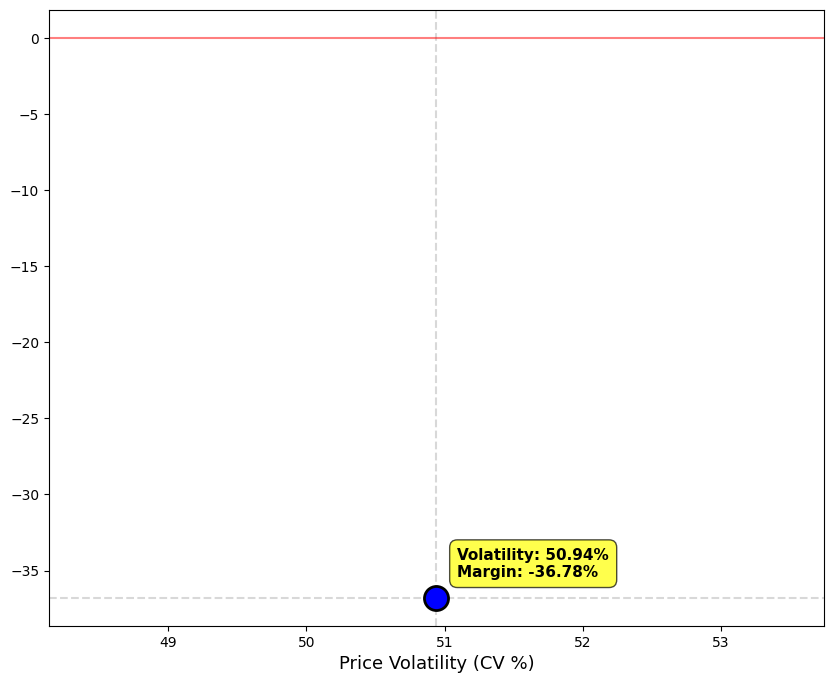

In [13]:
# Visualize the portfolio coordinate
import matplotlib.pyplot as plt

# Extract cost data from pipeline results
cost_summary = pipeline_results['cost_summary']
portfolio_result = pipeline_results['portfolio_result']

for tech_type, costs in cost_summary.items():
    print(f"\n{tech_type}:")
    print(f"  Production Cost:    {costs['production_cost_CHF']:>15,.2f} CHF")
    print(f"  Spot Purchases:     {costs['spot_buy_cost_CHF']:>15,.2f} CHF")
    print(f"  Spot Sales:        ({costs['spot_sell_revenue_CHF']:>15,.2f}) CHF")
    print(f"  Net Cost:           {costs['net_cost_CHF']:>15,.2f} CHF")


fig, ax = plt.subplots(figsize=(10, 8))

# Plot the portfolio point
ax.scatter(portfolio_result['x_volatility_pct'], portfolio_result['y_margin_pct'], 
          s=300, c='blue', marker='o', edgecolors='black', linewidth=2, 
          label='Current Portfolio', zorder=5)

# Add labels
ax.annotate(f"Volatility: {portfolio_result['x_volatility_pct']:.2f}%\nMargin: {portfolio_result['y_margin_pct']:.2f}%",
           xy=(portfolio_result['x_volatility_pct'], portfolio_result['y_margin_pct']),
           xytext=(15, 15), textcoords='offset points',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
           fontsize=11, fontweight='bold')

# Add reference lines
ax.axhline(y=portfolio_result['y_margin_pct'], color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=portfolio_result['x_volatility_pct'], color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, label='Break-even (0% margin)')

# Styling
ax.set_xlabel('Price Volatility (CV %)', fontsize=13, fontweigxsht='bold')
ax.set_ylabel('Savings Margin (%)', fontsize=13, fontweight='bold')
ax.set_title('PPU Portfolio Performance\n(2 PV + 2 Wind + 2 ROR)', 
            fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)

# Add quadrant labels
ax.text(0.98, 0.98, 'High Volatility\nHigh Margin', 
       transform=ax.transAxes, ha='right', va='top',
       fontsize=9, style='italic', alpha=0.5)
ax.text(0.02, 0.02, 'Low Volatility\nLow Margin', 
       transform=ax.transAxes, ha='left', va='bottom',
       fontsize=9, style='italic', alpha=0.5)

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n" + "=" * 80)
print("DETAILED COST BREAKDOWN")
print("=" * 80)


print("\n" + "=" * 80)
print(f"TOTAL PPU COST:        {portfolio_result['total_cost_CHF']:>15,.2f} CHF")
print(f"SPOT-ONLY COST:        {portfolio_result['spot_only_cost_CHF']:>15,.2f} CHF")
print(f"SAVINGS:               {portfolio_result['savings_CHF']:>15,.2f} CHF ({portfolio_result['y_margin_pct']:+.2f}%)")
print("=" * 80)

## Time Series Analysis

Detailed visualization of energy demand, pricing, PPU production, and storage levels throughout the simulation period.

In [23]:
# =============================================================================
# TIME SERIES VISUALIZATION
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create time index for plotting
time_index = demand_15min.index[:num_timesteps]

# Aggregate PPU production by technology type from Technology_volume
pv_production = np.zeros(num_timesteps)
wind_production = np.zeros(num_timesteps)
ror_production = np.zeros(num_timesteps)

# Extract production data from Technology_volume tracking
for tech_type, data in Technology_volume.items():
    for t, prod_MW in data['production']:
        if tech_type == 'PV':
            pv_production[t] += prod_MW
        elif tech_type == 'WIND_ONSHORE':
            wind_production[t] += prod_MW
        elif tech_type == 'HYD_ROR':
            ror_production[t] += prod_MW

# Create figure with subplots
fig, axes = plt.subplots(5, 1, figsize=(16, 14))
fig.suptitle('Energy System Analysis - Full Year 2024', fontsize=16, fontweight='bold', y=0.995)

# 1. Energy Demand
axes[0].plot(time_index, demand_15min.iloc[:num_timesteps], color='darkblue', linewidth=0.8, label='Demand')
axes[0].set_ylabel('Demand (MW)', fontsize=11, fontweight='bold')
axes[0].set_title('Energy Demand', fontsize=12, fontweight='bold', loc='left')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')
axes[0].set_xlim(time_index[0], time_index[-1])

# 2. Spot Price
axes[1].plot(time_index, spot_15min.iloc[:num_timesteps], color='darkgreen', linewidth=0.8, label='Spot Price')
axes[1].set_ylabel('Price (CHF/MWh)', fontsize=11, fontweight='bold')
axes[1].set_title('Spot Market Price', fontsize=12, fontweight='bold', loc='left')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper right')
axes[1].set_xlim(time_index[0], time_index[-1])

# 3. PPU Production by Type
axes[2].plot(time_index, pv_production, color='orange', linewidth=0.8, label='Solar PV', alpha=0.8)
axes[2].plot(time_index, wind_production, color='skyblue', linewidth=0.8, label='Wind', alpha=0.8)
axes[2].plot(time_index, ror_production, color='steelblue', linewidth=0.8, label='Run-of-River', alpha=0.8)
axes[2].set_ylabel('Production (MWh)', fontsize=11, fontweight='bold')
axes[2].set_title('PPU Production by Technology Type', fontsize=12, fontweight='bold', loc='left')
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc='upper right')
axes[2].set_xlim(time_index[0], time_index[-1])

# 4. Total Production vs Demand
total_production = pv_production + wind_production + ror_production
axes[3].fill_between(time_index, 0, total_production, color='lightgreen', alpha=0.5, label='Total PPU Production')
axes[3].plot(time_index, demand_15min.iloc[:num_timesteps], color='darkred', linewidth=1.0, label='Demand', linestyle='--')
axes[3].set_ylabel('Energy (MWh)', fontsize=11, fontweight='bold')
axes[3].set_title('Total Production vs Demand', fontsize=12, fontweight='bold', loc='left')
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper right')
axes[3].set_xlim(time_index[0], time_index[-1])

# 5. Storage Level (placeholder - all zeros since no storage implemented yet)
storage_level = np.zeros(num_timesteps)
axes[4].plot(time_index, storage_level, color='purple', linewidth=1.0, label='Storage Level')
axes[4].set_ylabel('Energy (MWh)', fontsize=11, fontweight='bold')
axes[4].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[4].set_title('Storage State of Charge (Not Implemented)', fontsize=12, fontweight='bold', loc='left')
axes[4].grid(True, alpha=0.3)
axes[4].legend(loc='upper right')
axes[4].set_xlim(time_index[0], time_index[-1])
axes[4].text(0.5, 0.5, 'Storage PPUs not yet implemented\n(H2, Battery, Lake)', 
            transform=axes[4].transAxes, ha='center', va='center',
            fontsize=12, style='italic', alpha=0.4)

# Format x-axis dates for all subplots
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n✓ Time series visualization complete")

NameError: name 'demand_15min' is not defined

In [24]:
# Check what PPUs are in the dictionary
print("PPUs in dictionary:")
for name in sorted(ppu_dictionary['PPU_Name'].unique()):
    print(f"  {name}")

print(f"\nTotal PPUs: {len(ppu_dictionary)}")

# Check Incidence PPUs specifically
incidence_ppus = ppu_dictionary[ppu_dictionary['PPU_Extract'] == 'Incidence']
print(f"\nIncidence PPUs ({len(incidence_ppus)}):")
for name in sorted(incidence_ppus['PPU_Name'].unique()):
    print(f"  {name}")

PPUs in dictionary:
  H2_G
  HYD_S
  PV
  SOL_SALT
  WD_OFF

Total PPUs: 5

Incidence PPUs (1):
  HYD_S


In [ ]:
# ============================================================================
# TEST: Verify Updated PPU Dictionary Functions
# ============================================================================

import importlib
import calculationsPpuFramework
importlib.reload(calculationsPpuFramework)
from calculationsPpuFramework import initialize_ppu_dictionary, add_ppu_to_dictionary, verify_storage_capacity

print("Testing updated PPU dictionary functions...")
print("="*80)

# Test 1: Initialize dictionary
print("\n1. Testing initialize_ppu_dictionary()...")
ppu_dict = initialize_ppu_dictionary()
print(f"✓ Dictionary initialized with columns: {list(ppu_dict.columns)}")
print(f"✓ Expected columns present: {'can_extract_from' in ppu_dict.columns and 'can_input_to' in ppu_dict.columns}")

# Test 2: Add a PPU
print("\n2. Testing add_ppu_to_dictionary()...")
try:
    updated_dict = add_ppu_to_dictionary(
        ppu_dictionary=ppu_dict,
        ppu_name='HYD_S',
        ppu_constructs_df=ppu_constructs_df,
        cost_df=cost_df,
        solar_locations_df=solar_locations_df,
        wind_locations_df=wind_locations_df,
        delta_t=hyperparams['delta_t'],
        raw_energy_storage=raw_energy_storage
    )
    print("✓ HYD_S added successfully")
    print(f"✓ Dictionary now has {len(updated_dict)} PPUs")
    hyd_s_row = updated_dict[updated_dict['PPU_Name'] == 'HYD_S']
    if not hyd_s_row.empty:
        print(f"✓ HYD_S can_extract_from: {hyd_s_row['can_extract_from'].iloc[0]}")
        print(f"✓ HYD_S can_input_to: {hyd_s_row['can_input_to'].iloc[0]}")
except Exception as e:
    print(f"✗ Error adding HYD_S: {e}")

# Test 3: Verify storage capacity
print("\n3. Testing verify_storage_capacity()...")
try:
    storage_check = verify_storage_capacity(updated_dict, raw_energy_storage, ppu_constructs_df)
    print("✓ Storage verification completed")
    print(f"✓ Storages in use: {storage_check['summary']['storages_in_use']}")
    print(f"✓ Total storages: {storage_check['summary']['total_storages']}")
except Exception as e:
    print(f"✗ Error in storage verification: {e}")

print("\n" + "="*80)
print("TEST COMPLETE - All functions working with new structure!")
print("="*80)